
# 1. Introduction

This notebook has been developed for the purposes of the EMPIR project “Metrology for the Factory of the Future” (Met4FoF) -  Activity A1.2.2 of the Work Package 1.Two laboratories in PTB and CEM posses conventional dynamic calibration set-ups for acceleration sensors under test. The objective of the task is to compare measurement results of the two laboratories, PTB and CEM, provided by the extended dynamic calibration systems. 

## 1.1. State of the art

In conventional dynamic calibration procedures for acceleration sensors, the acceleration used for the sensor input is applied either as **a sinusoidal excitation with a given frequency and amplitude** or as **a singular shock-like excitation characterized by pulse width and intensity**. 
<br>The quantity is then measured by a reference sensor and by the device under test (DUT). The results of DUT are compared to the reference and hence characterized and linked to the SI. In a dynamic calibration situation, the response of the DUT to time-varying input is the major interest. Hence, it is crucial that the mechanical input operates simultaneously and equally on the reference and DUT. Both, the reference and the DUT provide **electrical outputs (typical voltage)** while **the data acquisition electronics** of the system provides **the analogue to digital conversion (ADC).**
In order to connect the reference and the DUT to the ADC system, two analogue channels are needed. In order to get reliable information on the time dependent response, the timing of the data acquisition on the two channels has to be synchronized. This is typically accomplished by provision of a common clock signal to drive the sampling units of the ADC and a common trigger to start (or mark) the beginning of the acquisition. 

## 1.2. The extension of conventional dynamic calibration systems to digital-output sensors 

In a set-up where the DUT is a digital-output sensor,the sampling of the DUT time series is no longer under the control (trigger, clock) of the calibration system. Instead, the DUT comprises its own digitizer unit with a time base independent of the calibration system. In fact, a typical conventional calibration set-up does not provide an input for digital data at all.
The solution to this problem requires two extensions:
1.	A digital acquisition unit (DAU) which is capable to connect to the digital interface of the sensor under calibration and store/transmit the DUT time-series for later analysis
2.	An additional synchronization signal that provides the link between the time-base of the calibration system and the time-base of the DUT.

The concept for the extension of existing facilities for dynamic calibration uses a custom digital acquisition unit microcontroller board with a connected reference time signal for traceable time stamping of acquired data points. This allows for a synchronised data acquisition from the reference measurement and the DUT. The selected sensor for acceleration measurements is a three axial low-g acceleration sensor with digital output, which allows measurements of acceleration in three perpendicular axes.**At the moment and in this notebook, only an X-axis acceleration has been observed.** 
    
The selected laboratories posses their set-ups and the calibration item was calibrated in both set-ups.The analysis required transformation from time domain to the frequency domain, where frequencies and corresponding magnitudes and phases were calculated.The measurement conditions were kept according to the laboratory standard conditions. 

Each laboratory submitted HDF5 file containing groups:
- EXPERIMENTS - a group of 171 files (experiment) corresponding to the sine excitations
- RAWDATA - where data from ADCs (*voltage, absolute time, absolute time uncertainty*)  and sensors (*absolute time, absolute time uncertainty, acceleration, angular velocity, magnetic flux density and temperature*) can be approached during the measurements
- RAWTRANSFERFUNCTION - *this group contains quantities of interest: frequencies, amplitudes, assigned expanded uncertainties of amplitudes, phases,  assigned expanded uncertainties of phases, excitation amplitudes and assigned expanded uncertainties of excitation amplitudes
- REFERENCEDATA - reference data from ADCs and sensors.

    
| <b>PTB<b> | Sensor | Internal ADC |
| --- | --- | --- |
| <b>Name<b> | MPU 9250| STM 32 Internal ADC |
| <b>ID<b>  | 535035904 | 535038464 |
| <b>Quantity<b>  | X Acceleration | Voltage  @CH1 |
| <b>Unit<b>  | $\frac{m}{s^{2}}$ | V |    
| <b>Resolution<b>  | 65536,0 (16-bit) | 4096,0 (12-bit) |
| <b>Min. scale<b>  | -156,91439819335938 $\frac{m}{s^{2}}$  | -10 V |
| <b>Min. scale<b>  | 156,90960693359375 $\frac{m}{s^{2}}$  | 10 V |
    
| <b>CEM<b> | Sensor | Internal ADC |
| --- | --- | --- |
| <b>Name<b> | MPU 9250| STM 32 Internal ADC |
| <b>ID<b>  | 3167420416 | 31674422976 |
| <b>Quantity<b>  | X Acceleration | Voltage  @CH1 |
| <b>Unit<b>  | $\frac{m}{s^{2}}$ | V |    
| <b>Resolution<b>  | 65536,0 (16-bit) | 4096,0 (12-bit) |
| <b>Min. scale<b>  | -156,91439819335938 $\frac{m}{s^{2}}$  | -10 V |
| <b>Min. scale<b>  | 156,90960693359375 $\frac{m}{s^{2}}$  | 10 V |

In [1]:
import h5py
import numpy as np
import pandas as pd
import openpyxl
import matplotlib.pyplot as plt
import scipy.stats
import numpy as np
import scipy.stats as stats

import seaborn as sns
from ipywidgets import widgets, Layout
from IPython import display
import warnings
from scipy import stats



Bad key "text.kerning_factor" on line 4 in
C:\Users\EhlimanaJugo\anaconda3\envs\Ehlimana\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


# 2.Extract the data

Data for ILC comparison is extracted from the HDF5 files separately for PTB and CEM. The extracted data is sorted by frequency at the end of the Notebook and saved into Excel file.

In [2]:
def extract_data(filename, sensor_index):
    #explore the HDF5 file, folders and subfolders
    with h5py.File(filename,'r') as f:
        base_items=list(f.items())
        print("\nItems in directory", base_items)
        rawtransfer=f.get("RAWTRANSFERFUNCTION")
        rawtransfer_items=list(rawtransfer.items())
        print("\nItems in reference", rawtransfer_items)
        subgroup=rawtransfer.get("/RAWTRANSFERFUNCTION/"+sensor_index+"_MPU_9250")
        subgroup_items=list(subgroup.items())
        print("\n"+sensor_index+"_MPU_9250 items:",subgroup_items)
        subgroup_acceleration=subgroup.get("/RAWTRANSFERFUNCTION/"+sensor_index+"_MPU_9250/Acceleration")
        subgroup_acceleration_items=list(subgroup_acceleration.items())
        print("\nAcceleration items:",subgroup_acceleration_items)
        subgroup_acceleration_5mem=subgroup.get("/RAWTRANSFERFUNCTION/"+sensor_index+"_MPU_9250/Acceleration/Acceleration")
        subgroup_acceleration_5mem_items=list(subgroup_acceleration_5mem.items())
        print("\nAcceleration items_5members:", subgroup_acceleration_5mem_items)
        frequency=subgroup_acceleration_5mem.get("/RAWTRANSFERFUNCTION/"+sensor_index+"_MPU_9250/Acceleration/Acceleration/Frequency")
        frequency_items=list(frequency.items())
        print("\nFrequency", frequency_items)
        magnitude=subgroup_acceleration_5mem.get("/RAWTRANSFERFUNCTION/"+sensor_index+"_MPU_9250/Acceleration/Acceleration/Magnitude")
        magnitude_items=list(magnitude.items())
        print("\nMagnitude", magnitude_items)
        phase=subgroup_acceleration_5mem.get("/RAWTRANSFERFUNCTION/"+sensor_index+"_MPU_9250/Acceleration/Acceleration/Phase")
        phase_items=list(magnitude.items())
        print("\nPhase", phase_items)
        
        
        #extract frequencies, magnitude, phase, uncertainties and all excitation parameters
        frequency_values=np.array(frequency.get("value"))
        magnitude_values=np.array(magnitude.get("value"))
        magnitude_uncertainties=np.array(magnitude.get("uncertainty"))
        phase_values=np.array(phase.get("value"))
        phase_uncertainties=np.array(phase.get("uncertainty"))
        excitation_freq_items=subgroup_acceleration_5mem.get("/RAWTRANSFERFUNCTION/"+sensor_index+"_MPU_9250/Acceleration/Acceleration/Excitation_frequency")
        excitation_freq=np.array(excitation_freq_items.get("value"))
        excitation_amp_items=subgroup_acceleration_5mem.get("/RAWTRANSFERFUNCTION/"+sensor_index+"_MPU_9250/Acceleration/Acceleration/Excitation_amplitude")
        excitation_amp=np.array(excitation_amp_items.get("value"))
        excitation_amp_uncertainty=np.array(excitation_amp_items.get("uncertainty"))
        
        #join all necessary data in 2D array
        total_array=np.stack((frequency_values,magnitude_values,magnitude_uncertainties,phase_values, phase_uncertainties,excitation_freq,excitation_amp,excitation_amp_uncertainty), axis=1)
        print("\nArray dimensions:", total_array.shape)
        column_names=["Frequency [Hz]", r"$x_{M},$ [m s^-2/m s^-2]",r"$U_{M},$ [m s^-2/m s^-2]", r"$x_{\phi},$ [°]", r"$U_{\phi},$ [°]","Excitation_freq [Hz]",r"$x_{Aexcit},$ [m s^-2/m s^-2]",r"$U_{Aexcit},$ [m s^-2/m s^-2]"]
        whole_dataset=pd.DataFrame(total_array, columns=column_names)
        f.close()
        
        
        return whole_dataset

In [3]:
whole_dataset_PTB = extract_data('MPU9250PTB_v2.hdf5',"0x1fe40000")
#whole_dataset_PTB = extract_data('MPU9250PTB.hdf5',"0x1fe40000")


Items in directory [('EXPERIMENTS', <HDF5 group "/EXPERIMENTS" (1 members)>), ('RAWDATA', <HDF5 group "/RAWDATA" (2 members)>), ('RAWTRANSFERFUNCTION', <HDF5 group "/RAWTRANSFERFUNCTION" (1 members)>), ('REFERENCEDATA', <HDF5 group "/REFERENCEDATA" (2 members)>)]

Items in reference [('0x1fe40000_MPU_9250', <HDF5 group "/RAWTRANSFERFUNCTION/0x1fe40000_MPU_9250" (1 members)>)]

0x1fe40000_MPU_9250 items: [('Acceleration', <HDF5 group "/RAWTRANSFERFUNCTION/0x1fe40000_MPU_9250/Acceleration" (1 members)>)]

Acceleration items: [('Acceleration', <HDF5 group "/RAWTRANSFERFUNCTION/0x1fe40000_MPU_9250/Acceleration/Acceleration" (10 members)>)]

Acceleration items_5members: [('DUT_Phase', <HDF5 group "/RAWTRANSFERFUNCTION/0x1fe40000_MPU_9250/Acceleration/Acceleration/DUT_Phase" (2 members)>), ('DUT_SNYNC_Phase', <HDF5 group "/RAWTRANSFERFUNCTION/0x1fe40000_MPU_9250/Acceleration/Acceleration/DUT_SNYNC_Phase" (2 members)>), ('DUT_amplitude', <HDF5 group "/RAWTRANSFERFUNCTION/0x1fe40000_MPU_9250/

In [4]:
whole_dataset_PTB.head(2)

Frequency [Hz]  $x_{M},$ [m s^-2/m s^-2]  $U_{M},$ [m s^-2/m s^-2]  \
0            10.0                  1.019399                  0.002580   
1            12.5                  1.018809                  0.002819   

   $x_{\phi},$ [°]  $U_{\phi},$ [°]  Excitation_freq [Hz]  \
0         3.046626         0.002696                  10.0   
1         3.022957         0.006221                  12.5   

   $x_{Aexcit},$ [m s^-2/m s^-2]  $U_{Aexcit},$ [m s^-2/m s^-2]  
0                          2.739                       0.000548  
1                          2.744                       0.000549

Phase data for PTB must be reverted:

In [5]:

whole_dataset_PTB[[r"$x_{\phi},$ [°]"]] = whole_dataset_PTB[[r"$x_{\phi},$ [°]"]]-np.pi
whole_dataset_PTB.head(2)

Frequency [Hz]  $x_{M},$ [m s^-2/m s^-2]  $U_{M},$ [m s^-2/m s^-2]  \
0            10.0                  1.019399                  0.002580   
1            12.5                  1.018809                  0.002819   

   $x_{\phi},$ [°]  $U_{\phi},$ [°]  Excitation_freq [Hz]  \
0        -0.094967         0.002696                  10.0   
1        -0.118636         0.006221                  12.5   

   $x_{Aexcit},$ [m s^-2/m s^-2]  $U_{Aexcit},$ [m s^-2/m s^-2]  
0                          2.739                       0.000548  
1                          2.744                       0.000549

In [6]:
whole_dataset_CEM = extract_data('MPU9250CEM_v2.hdf5',"0xbccb0000")
#whole_dataset_CEM = extract_data('MPU9250CEM.hdf5',"0xbccb0000")


Items in directory [('EXPERIMENTS', <HDF5 group "/EXPERIMENTS" (1 members)>), ('RAWDATA', <HDF5 group "/RAWDATA" (2 members)>), ('RAWTRANSFERFUNCTION', <HDF5 group "/RAWTRANSFERFUNCTION" (1 members)>), ('REFERENCEDATA', <HDF5 group "/REFERENCEDATA" (2 members)>)]

Items in reference [('0xbccb0000_MPU_9250', <HDF5 group "/RAWTRANSFERFUNCTION/0xbccb0000_MPU_9250" (1 members)>)]

0xbccb0000_MPU_9250 items: [('Acceleration', <HDF5 group "/RAWTRANSFERFUNCTION/0xbccb0000_MPU_9250/Acceleration" (1 members)>)]

Acceleration items: [('Acceleration', <HDF5 group "/RAWTRANSFERFUNCTION/0xbccb0000_MPU_9250/Acceleration/Acceleration" (10 members)>)]

Acceleration items_5members: [('DUT_Phase', <HDF5 group "/RAWTRANSFERFUNCTION/0xbccb0000_MPU_9250/Acceleration/Acceleration/DUT_Phase" (2 members)>), ('DUT_SNYNC_Phase', <HDF5 group "/RAWTRANSFERFUNCTION/0xbccb0000_MPU_9250/Acceleration/Acceleration/DUT_SNYNC_Phase" (2 members)>), ('DUT_amplitude', <HDF5 group "/RAWTRANSFERFUNCTION/0xbccb0000_MPU_9250/

In [7]:
whole_dataset_CEM.head(2)

Frequency [Hz]  $x_{M},$ [m s^-2/m s^-2]  $U_{M},$ [m s^-2/m s^-2]  \
0            80.0                  0.973553                  0.001457   
1           250.0                  0.642955                  0.000849   

   $x_{\phi},$ [°]  $U_{\phi},$ [°]  Excitation_freq [Hz]  \
0        -0.759668         0.003082                  80.0   
1        -2.375349         0.063520                 250.0   

   $x_{Aexcit},$ [m s^-2/m s^-2]  $U_{Aexcit},$ [m s^-2/m s^-2]  
0                         10.011                       0.010011  
1                        126.500                       0.126500

In [8]:
#whole_dataset_CEM[['Phase [°]']] = whole_dataset_CEM[['Phase [°]']]-np.pi
#whole_dataset_CEM.head(2)

# 3.Data analysis

## 3.1 Introduction plots

In [9]:
def plot_dataset(dataset,name):
    plt.figure(figsize=(15,10))
    plt.subplot(311)
    plt.plot(dataset[r"$x_{M},$ [m s^-2/m s^-2]"])
    plt.ylabel(r"$x_{M},$ [m s^-2/m s^-2]")
    plt.xlabel("Experiments")
    plt.title(name)

    plt.subplot(312)
    plt.plot(dataset[r"$x_{\phi},$ [°]"])
    plt.ylabel(r"$x_{\phi},$ [°]")
    plt.xlabel("Experiments")

    plt.subplot(313)
    plt.plot(dataset[r"$x_{Aexcit},$ [m s^-2/m s^-2]"])
    plt.ylabel(r"$x_{Aexcit},$ [m s^-2/m s^-2]")
    plt.xlabel("Experiments")
    plt.show()

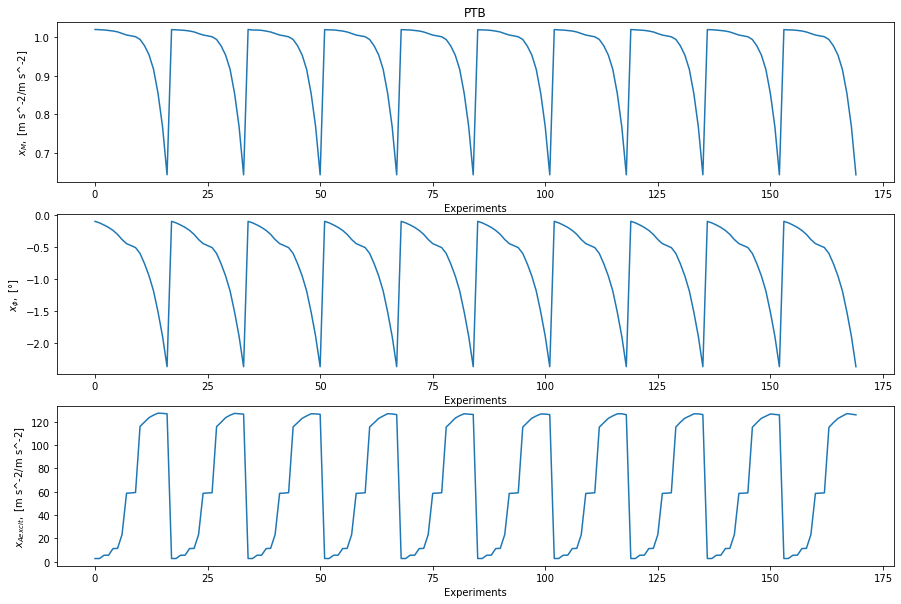

In [10]:
plot_dataset(whole_dataset_PTB,"PTB")

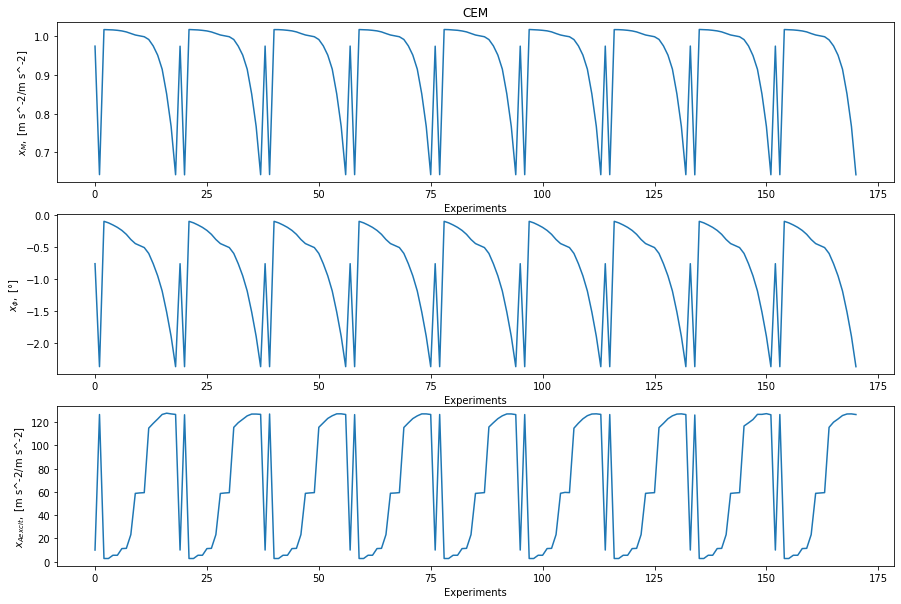

In [11]:
plot_dataset(whole_dataset_CEM,"CEM")
# peaks are individual behaviour, the system at CEM works in a way that starts with the freq of 80 Hz.

Graphs show measurement cycles, where each poing on x-axis corresponds to the one experiment. PTB conducted 10 measurement cycles, resulting in ten values for magnitude and phase at each calibration point (frequency in a range from 10.0 Hz and 250 Hz). Cycles in CEM's dataset start with 80.0 Hz and 250.0 Hz instead of 10.0 Hz, which is the consequence of the current set-up. These starting points are deleted in order to compare the cycles in a range from 10.0 Hz and 250 Hz and the total number of measurement cycles for the corrected CEM data is 9, meaning that there are nine values for magnitude and phase at each calibration point.

In [12]:
delete_rows=[]

for k in range(0,171,19):
    i=k
    j=k+1
    delete_rows.append(i)
    delete_rows.append(j)
whole_dataset_CEM_new=whole_dataset_CEM.drop(axis=0,index=delete_rows)

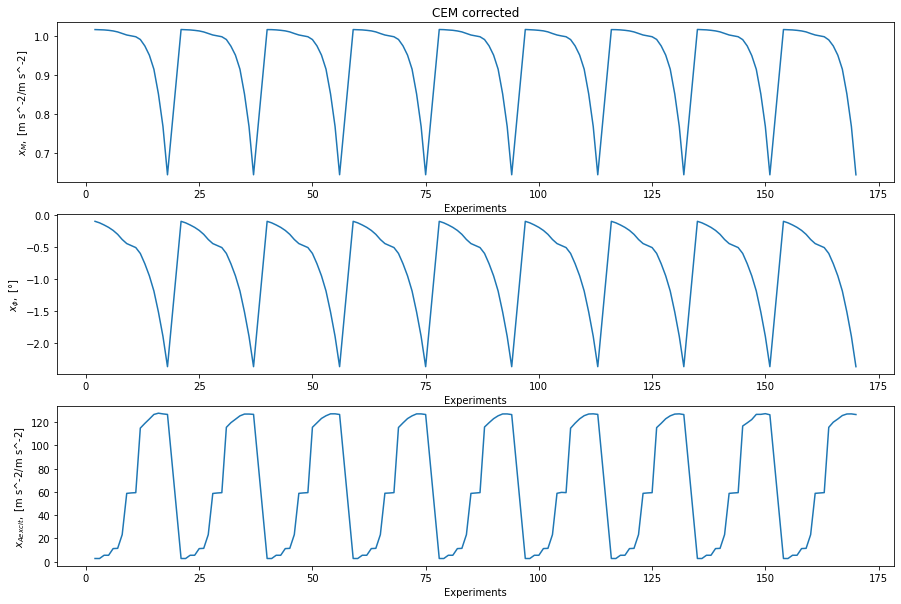

In [13]:
plot_dataset(whole_dataset_CEM_new,"CEM corrected")


The calibration procedure for PTB and CEM was conducted in a similar way and the further analysis covers the examination of changes in mangitudes and phases on different frequencies. The first calibration point is at 10 Hz because the shaker in the calibration system should be bigger in order to achieve lower frequencies.  Moreover, digital sensors have integrated temperature sensor. High influence of the temperature should be visible for magnitude but phase does not suffer the high influence of the temperature. Additionally, some variations are present for excitation amplitude values because it is hard to achieve the targeted values (usually vary around 1%).

In [14]:
def split_data_by_frequencies(dataset):
    dict_of_frequencies=dict(iter(dataset.groupby('Frequency [Hz]')))
    return dict_of_frequencies
    #list_of_frequencies=np.array([10,12.5,16,20,25,31.5,40,46.7,50,53.3,63,80,100,125,160,200,250])

In [15]:
#check if all frequencies are the same
PTB_separated_by_freq=split_data_by_frequencies(whole_dataset_PTB)
CEM_separated_by_freq=split_data_by_frequencies(whole_dataset_CEM)
CEM_separated_by_freq_new=split_data_by_frequencies(whole_dataset_CEM_new)
print("Frequencies - PTB:",PTB_separated_by_freq.keys())
print("Frequencies - CEM:",CEM_separated_by_freq.keys())

Frequencies - PTB: dict_keys([10.0, 12.5, 16.0, 20.0, 25.0, 31.5, 40.0, 46.7, 50.0, 53.3, 63.0, 80.0, 100.0, 125.0, 160.0, 200.0, 250.0])
Frequencies - CEM: dict_keys([10.0, 12.5, 16.0, 20.0, 25.0, 31.5, 40.0, 46.7, 50.0, 53.3, 63.0, 80.0, 100.0, 125.0, 160.0, 200.0, 250.0])


In [16]:
PTB_separated_by_freq.get(10).head(1)

Frequency [Hz]  $x_{M},$ [m s^-2/m s^-2]  $U_{M},$ [m s^-2/m s^-2]  \
0            10.0                  1.019399                   0.00258   

   $x_{\phi},$ [°]  $U_{\phi},$ [°]  Excitation_freq [Hz]  \
0        -0.094967         0.002696                  10.0   

   $x_{Aexcit},$ [m s^-2/m s^-2]  $U_{Aexcit},$ [m s^-2/m s^-2]  
0                          2.739                       0.000548

In [17]:
CEM_separated_by_freq_new.get(10).head(1)

Frequency [Hz]  $x_{M},$ [m s^-2/m s^-2]  $U_{M},$ [m s^-2/m s^-2]  \
2            10.0                  1.016208                  0.004531   

   $x_{\phi},$ [°]  $U_{\phi},$ [°]  Excitation_freq [Hz]  \
2        -0.094907         0.022714                  10.0   

   $x_{Aexcit},$ [m s^-2/m s^-2]  $U_{Aexcit},$ [m s^-2/m s^-2]  
2                         2.7543                       0.002754

In [18]:
q_names=list(PTB_separated_by_freq.get(10).columns)

The quantities of interest from the dictionaries are ${x_{M}},{x_{\phi}}$, with assigned expanded uncertainties ${U_{M}},{U_{\phi}}$.


The interval of  ${x_{i}} -\sigma _{i}$ and ${x_{i}} +\sigma _{i}$  is plotted for each cycle and frequency, where $\sigma _{i}$ is calculated as   $\frac{U _{i}}{2}$.

In [19]:
def plot_x_plus_minus_sigma(dictionary,names):
    range_mag,range_ph,index_mag=np.empty(len(dictionary.values())),np.empty(len(dictionary.values())),np.empty(len(dictionary.values()))
    index_ph=np.empty(len(dictionary.values()))
    for i,val in enumerate(dictionary.values()):
        data_dict_mag = {}
        data_dict_mag['cycle'] =list(range(len(val)))
        data_dict_mag['lower'] = val[r"$x_{M},$ [m s^-2/m s^-2]"].values-val[r"$U_{M},$ [m s^-2/m s^-2]"].values/2
        data_dict_mag['upper'] = val[r"$x_{M},$ [m s^-2/m s^-2]"].values+val[r"$U_{M},$ [m s^-2/m s^-2]"].values/2
        dataset_mag = pd.DataFrame(data_dict_mag)
        range_mag[i]=(dataset_mag['upper']-dataset_mag['lower']).max()
        index_mag[i]=(dataset_mag['upper']-dataset_mag['lower']).idxmax()
        
        data_dict_phase = {}
        data_dict_phase['cycle'] =list(range(len(val)))
        data_dict_phase['lower'] = val[r"$x_{\phi},$ [°]"].values-val[r"$U_{\phi},$ [°]"].values/2
        data_dict_phase['upper'] = val[r"$x_{\phi},$ [°]"].values+val[r"$U_{\phi},$ [°]"].values/2
        dataset_phase = pd.DataFrame(data_dict_phase)
        range_ph[i]=(dataset_phase['upper']-dataset_phase['lower']).max()
        index_ph[i]=(dataset_phase['upper']-dataset_phase['lower']).idxmax()
        #data_dict_excit = {}
        #data_dict_excit['cycle'] =list(range(len(val)))
        #data_dict_excit['lower'] = val[r"$x_{Aexcit},$ [m s^-2/m s^-2]"].values-val[r"$U_{Aexcit},$ [m s^-2/m s^-2]"].values/2
        #data_dict_excit['upper'] = val[r"$x_{Aexcit},$ [m s^-2/m s^-2]"].values+val[r"$U_{Aexcit},$ [m s^-2/m s^-2]"].values/2
        #dataset_excit = pd.DataFrame(data_dict_excit)


        plt.figure(figsize=(15,5))
        plt.subplot(1,2,1)

        for lower,upper,y in zip(dataset_mag['lower'],dataset_mag['upper'],range(len(dataset_mag))):
            plt.plot((lower,upper),(y,y),'ro-',color='orange')
        plt.yticks(range(len(dataset_mag)),list(dataset_mag['cycle']))
        plt.title(str(val[names[0]].values[0])+" Hz")
        plt.xlabel("Magnitude, [m s^-2/m s^-2]")
        plt.ylabel("Measurement cycle")

        plt.subplot(1,2,2)
        for lower,upper,y in zip(dataset_phase['lower'],dataset_phase['upper'],range(len(dataset_phase))):
            plt.plot((lower,upper),(y,y),'ro-',color='orange')
        plt.yticks(range(len(dataset_phase)),list(dataset_phase['cycle']))
        plt.title(str(val[names[0]].values[0])+" Hz")
        plt.xlabel("Phase, [°]")
        plt.ylabel("Measurement cycle")

        #plt.subplot(1,3,3)
        #for lower,upper,y in zip(dataset_excit['lower'],dataset_excit['upper'],range(len(dataset_excit))):
            #plt.plot((lower,upper),(y,y),'ro-',color='orange')
        #plt.yticks(range(len(dataset_excit)),list(dataset_excit['cycle']))
        #plt.xlabel("Excitation amplitude")
        #plt.ylabel("Measurement cycle")
        #plt.title(str(val[names[0]].values[0])+" Hz")
    plt.show()
    range_mag=pd.DataFrame(range_mag,index=[10.0, 12.5, 16.0, 20.0, 25.0, 31.5, 40.0, 46.7, 50.0, 53.3, 63.0, 80.0, 100.0, 125.0, 160.0, 200.0, 250.0],columns=["Magntiude range, [m s^-2/m s^-2]"])
    range_ph=pd.DataFrame(range_ph,index=[10.0, 12.5, 16.0, 20.0, 25.0, 31.5, 40.0, 46.7, 50.0, 53.3, 63.0, 80.0, 100.0, 125.0, 160.0, 200.0, 250.0],columns=["Phase range, [°]"])
    index_mag=pd.DataFrame(index_mag,index=[10.0, 12.5, 16.0, 20.0, 25.0, 31.5, 40.0, 46.7, 50.0, 53.3, 63.0, 80.0, 100.0, 125.0, 160.0, 200.0, 250.0],columns=["Index_M"])
    index_ph=pd.DataFrame(index_ph,index=[10.0, 12.5, 16.0, 20.0, 25.0, 31.5, 40.0, 46.7, 50.0, 53.3, 63.0, 80.0, 100.0, 125.0, 160.0, 200.0, 250.0],columns=["Index_Ph"])
    
    return range_mag,range_ph,index_mag,index_ph

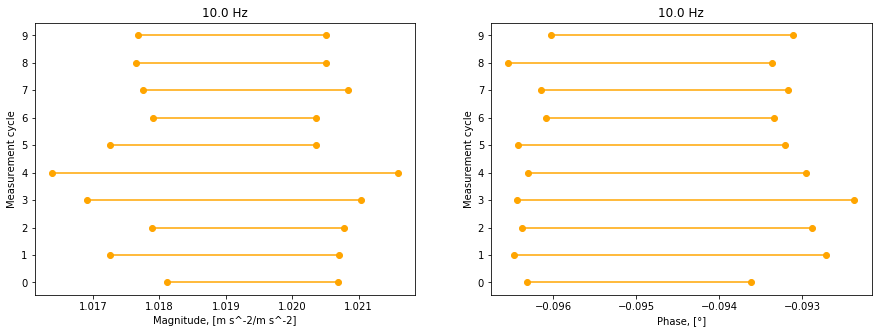

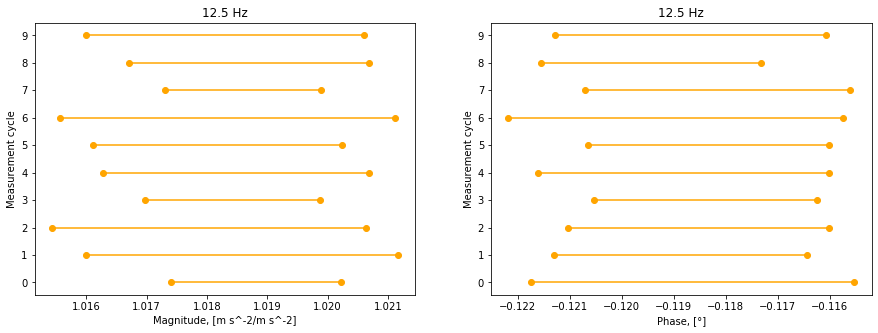

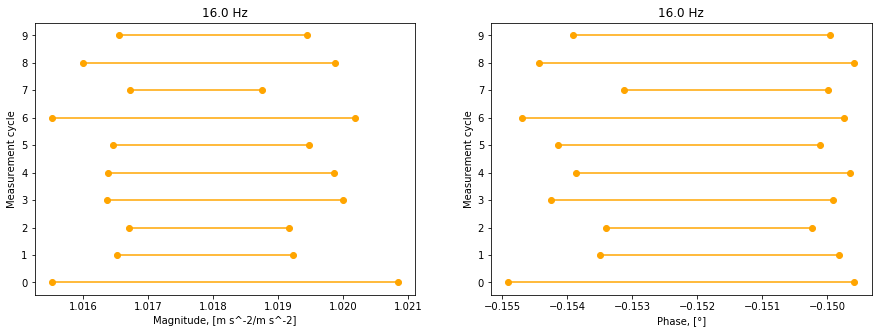

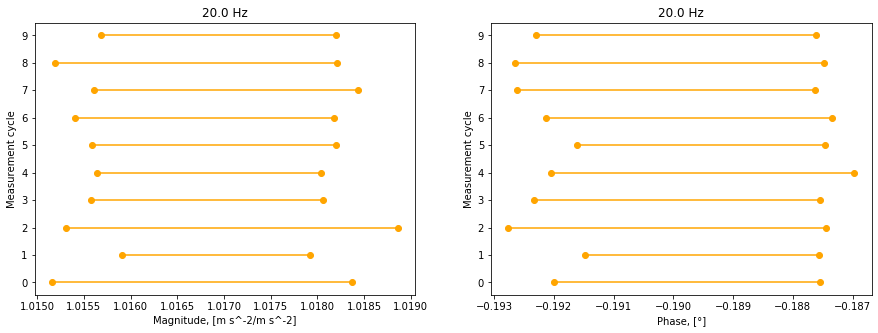

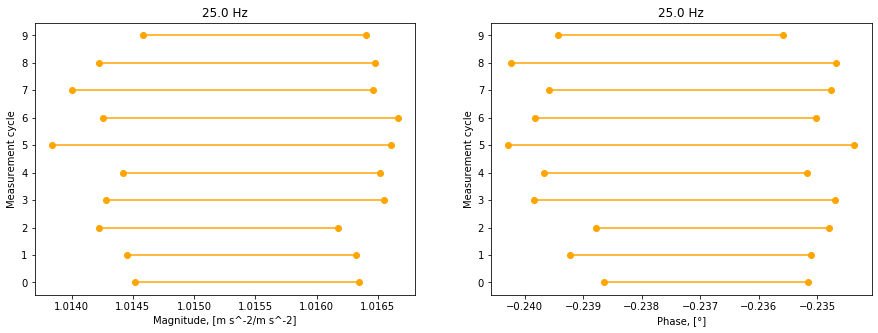

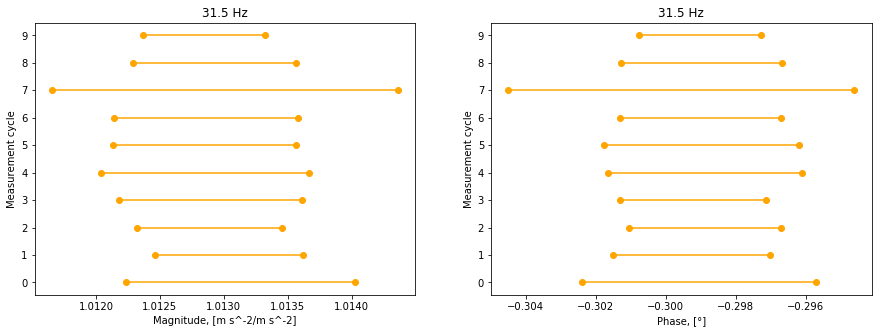

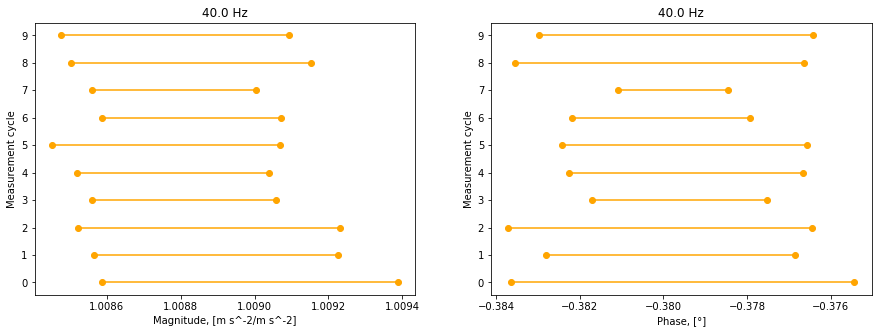

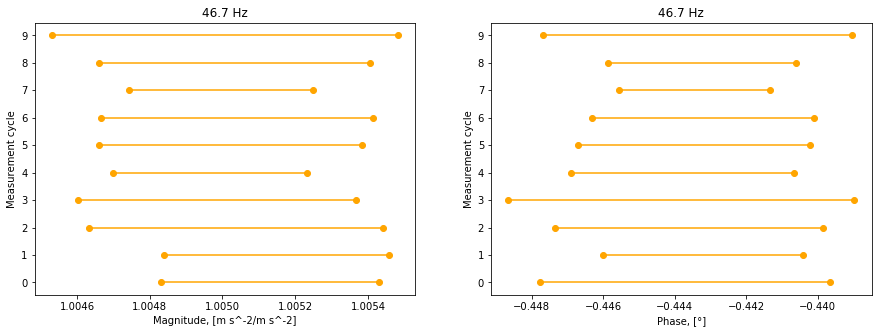

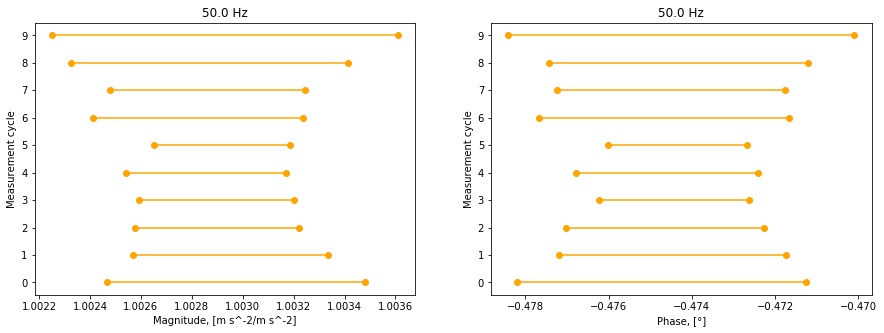

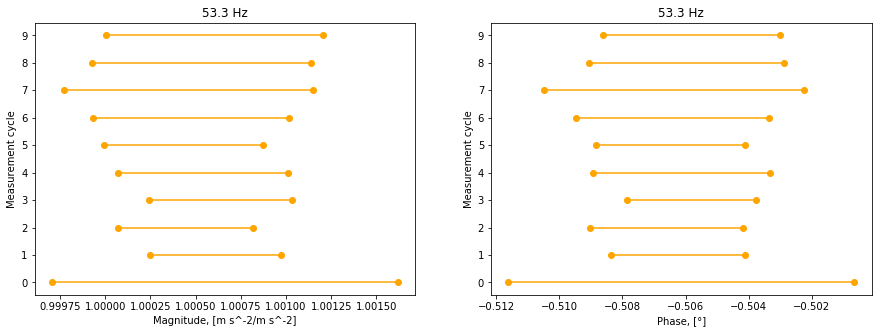

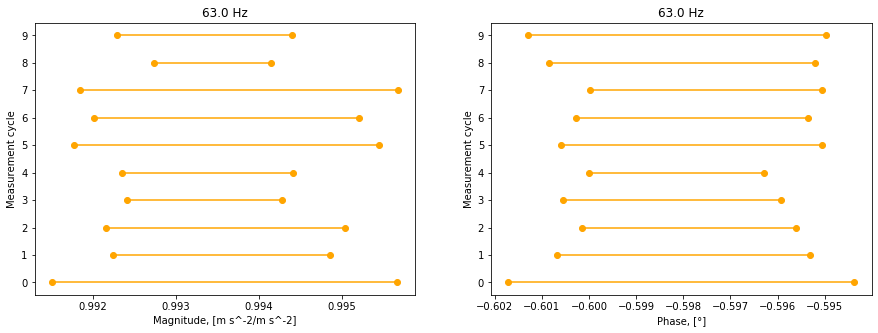

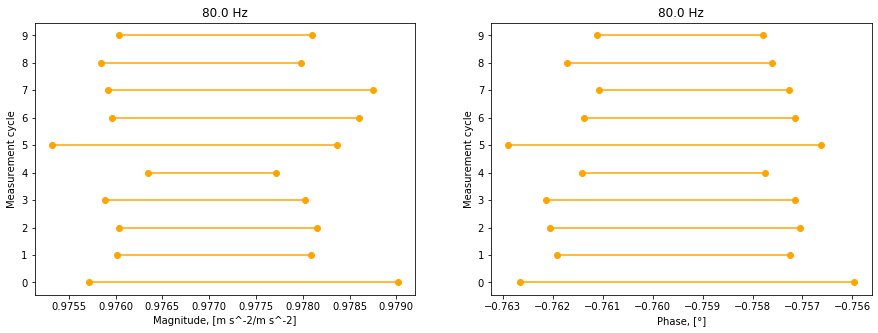

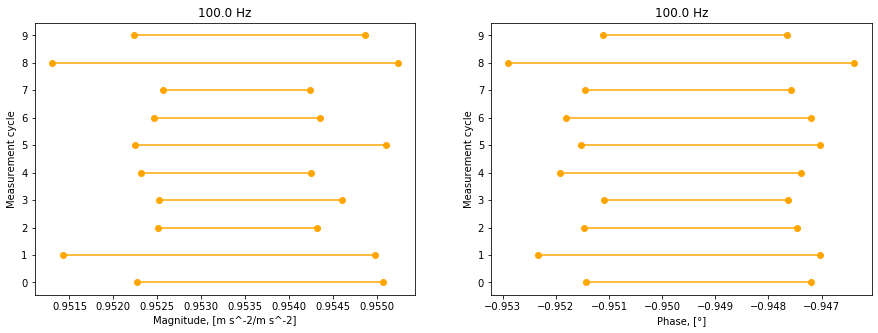

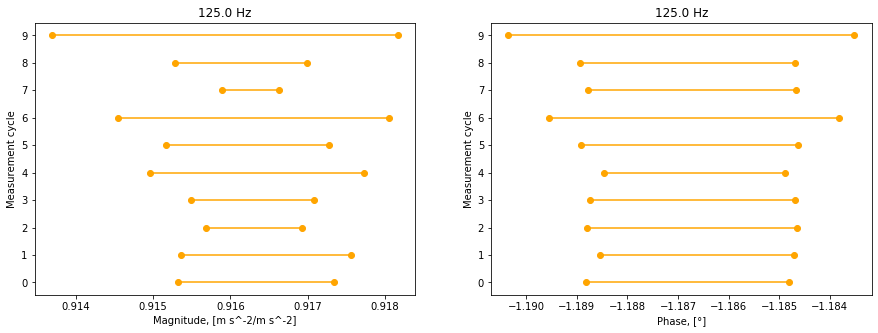

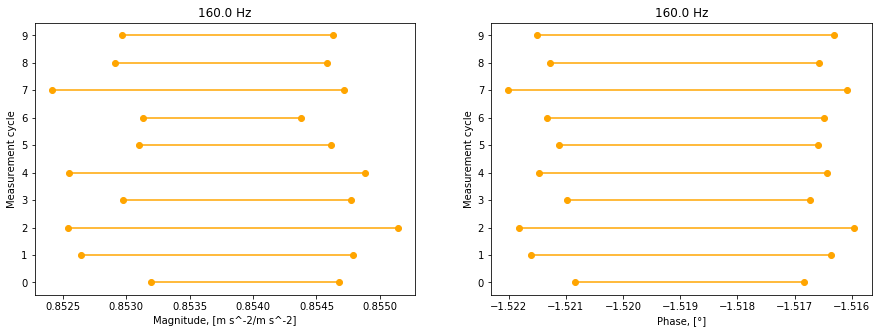

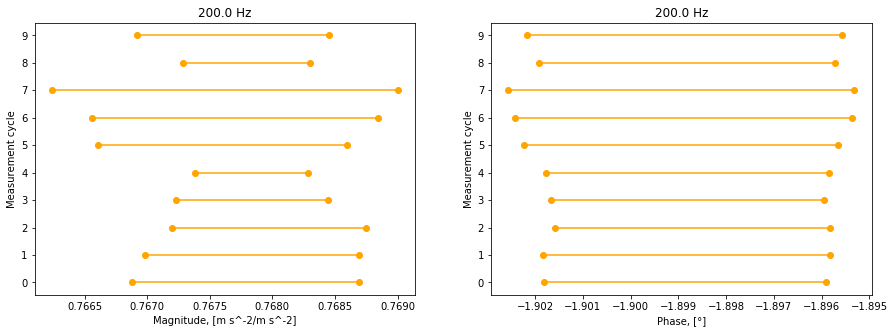

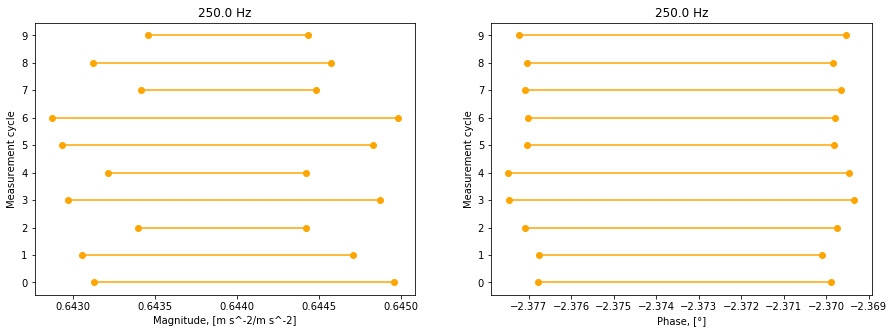

In [20]:
range_mag_PTB,range_ph_PTB,index_mag_PTB,index_ph_PTB=plot_x_plus_minus_sigma(PTB_separated_by_freq,q_names)


Plots show that the intervals based on the values  ($ {x_{i}} -\sigma _{i}$ and ${x_{i}} +\sigma _{i}$) vary within different experiments at a specific frequency. Some experiments have wide interval and some intervals are narrow. Therefore, the next step is to find the widest intervals at each frequency, which actually corresponds to the experiment with the highest expanded uncertainty (${x_{i}} +\sigma _{i} - ({x_{i}} -\sigma _{i}) = 2*\sigma _{i} = U _{i}$)

In [21]:
# create output widgets
widget1 = widgets.Output()
widget2 = widgets.Output()
cm = sns.light_palette("green", as_cmap=True)

with widget1:
    display.display(range_mag_PTB.style.set_caption('Magnitude range').background_gradient(cmap=cm))

with widget2:
    display.display(range_ph_PTB.style.set_caption('Phase range').background_gradient(cmap=cm))


# add some CSS styles to distribute free space
box_layout = Layout(display='flex',
                    flex_flow='row',
                    justify_content='space-around',
                    width='auto'
                   )
    
# create Horisontal Box container
hbox = widgets.HBox([widget1, widget2], layout=box_layout)

# render hbox
hbox

The plots and dataframes from PTB show that highest uncertainties for the magnitudes are in the frequency intervals: 
<br> between 10.0 Hz and 16.0 Hz and
<br> between 63.0 Hz and 125.0 Hz.
<br>The lowest uncertainties for the magnitude values are in a range (40.0 - 53.3) Hz. The known fact is that the system is thumbling and is unstable at these frequencies - the consequence of mechanical problems.

<br>The highest uncertainties for the phases are in the frequency interval:
<br> between 31.5 Hz and 53.3 Hz.
<br>The lowest uncertainties for the phase values are in a range (10.0- 25) Hz

The uncertainties do not show a generic behaviour when changing the frequency ( for example, the phase uncertainties decrease in a range between (63.0 and 160. Hz) and than increase again in arange (200.0 - 250.0) Hz.

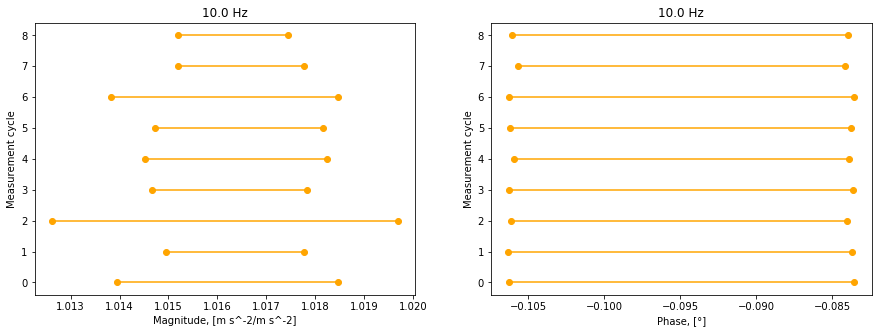

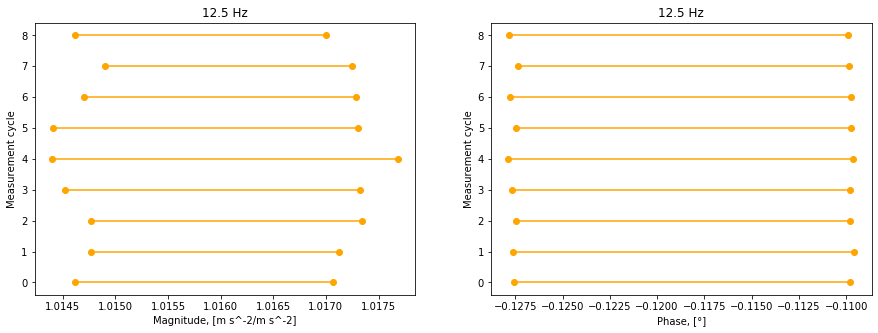

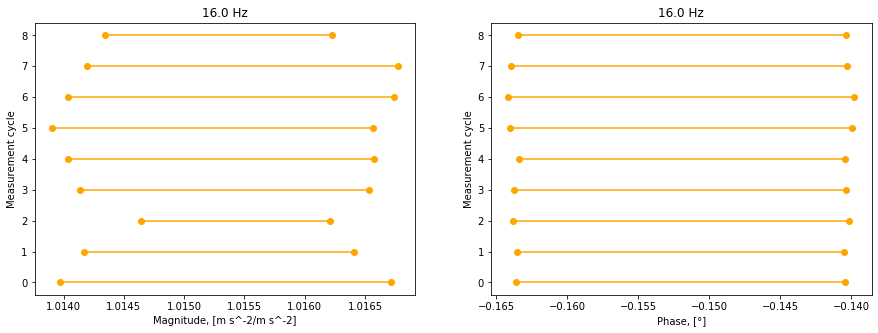

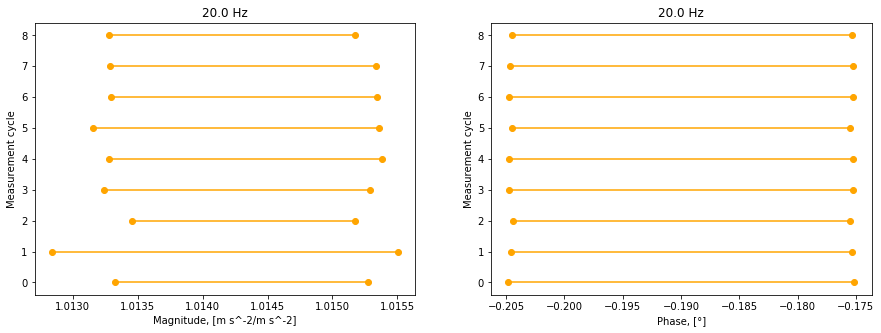

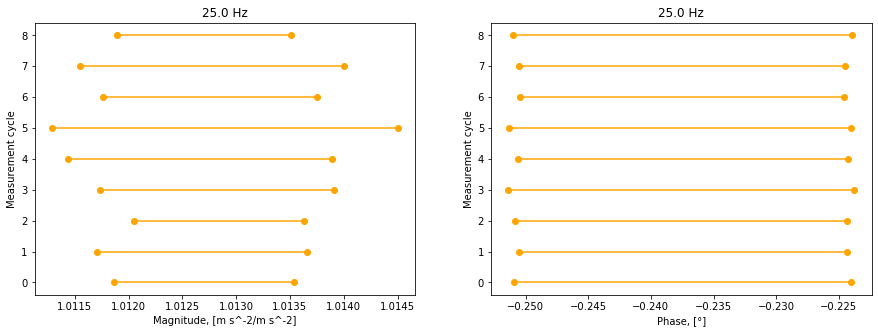

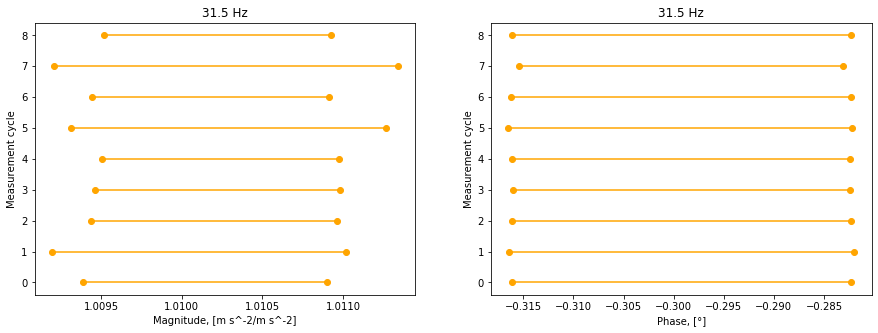

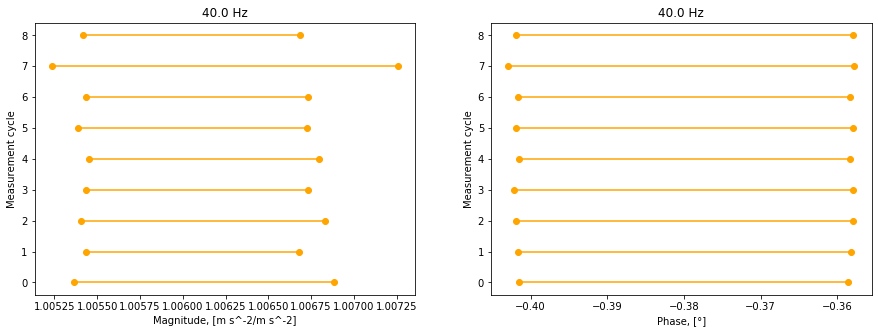

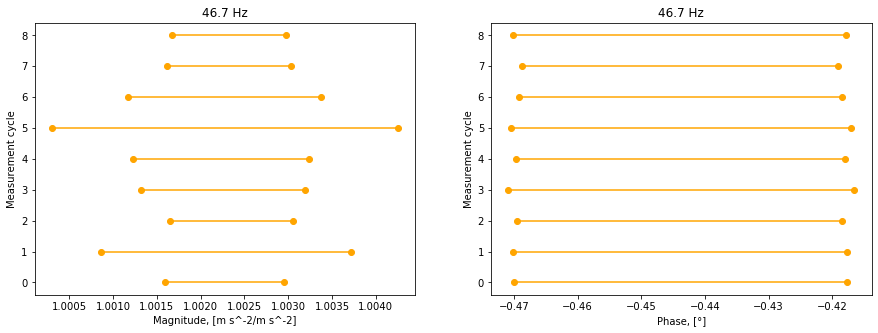

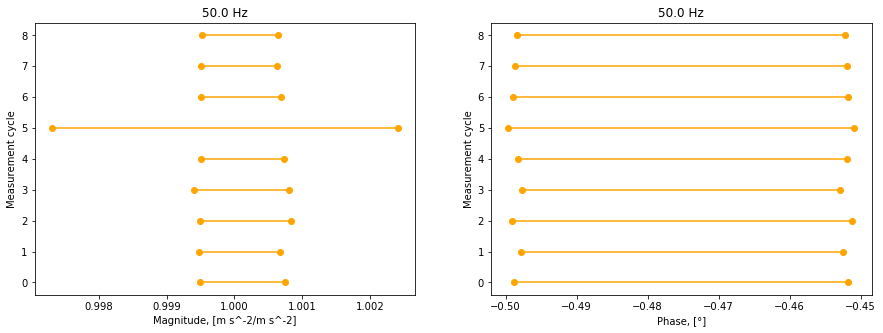

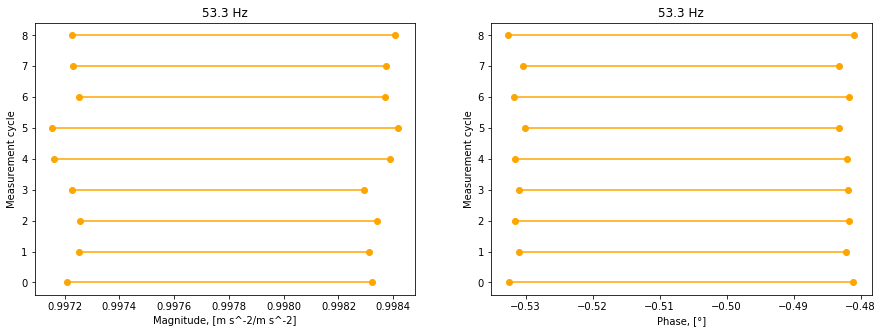

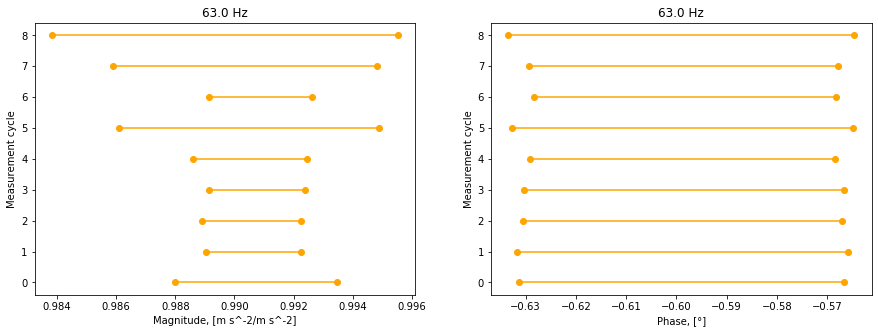

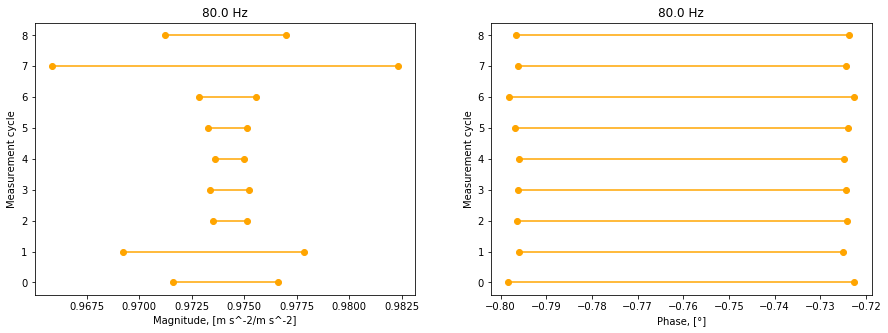

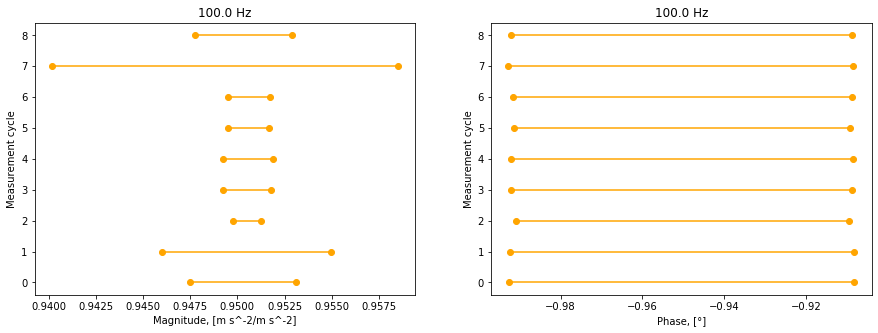

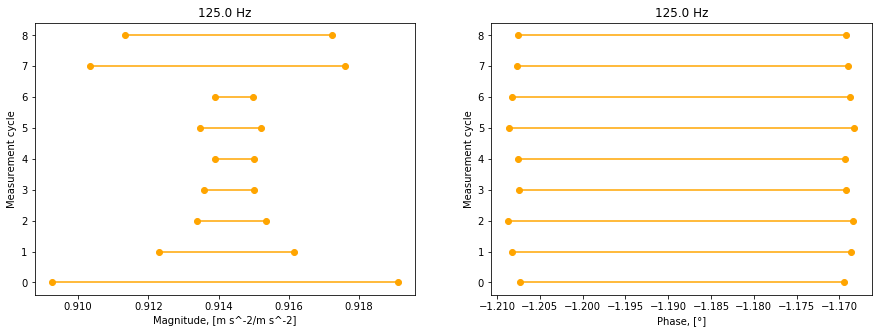

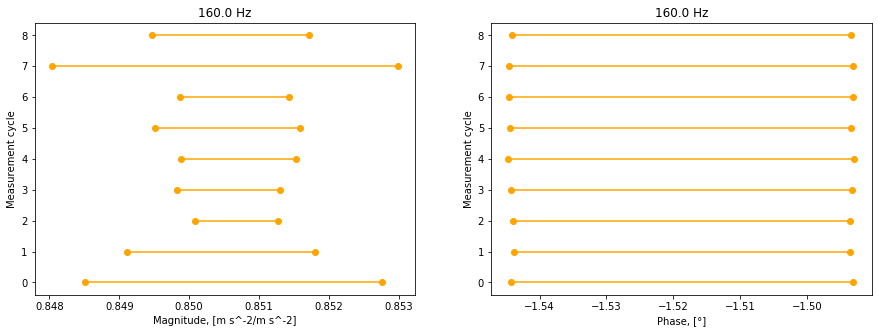

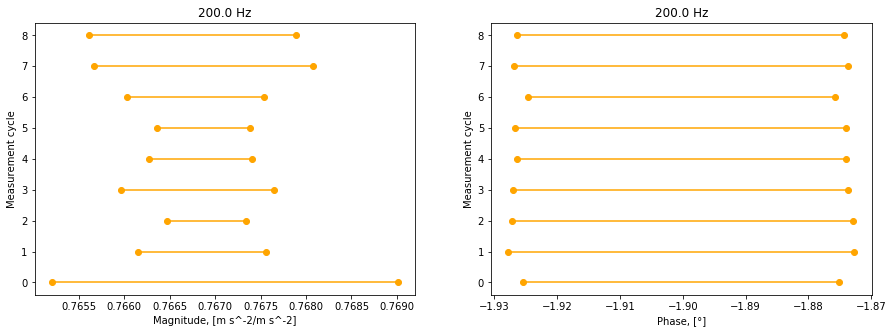

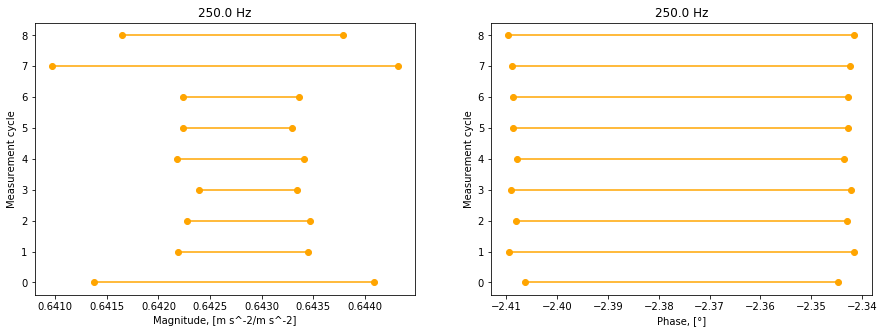

In [22]:
range_mag_CEM,range_ph_CEM,index_mag_CEM,index_ph_CEM=plot_x_plus_minus_sigma(CEM_separated_by_freq_new,q_names)

In [23]:
# create output widgets
widget1 = widgets.Output()
widget2 = widgets.Output()
cm = sns.light_palette("green", as_cmap=True)

with widget1:
    display.display(range_mag_CEM.style.set_caption('Magnitude range').background_gradient(cmap=cm))

with widget2:
    display.display(range_ph_CEM.style.set_caption('Phase range').background_gradient(cmap=cm))


# add some CSS styles to distribute free space
box_layout = Layout(display='flex',
                    flex_flow='row',
                    justify_content='space-around',
                    width='auto'
                   )
    
# create Horisontal Box container
hbox = widgets.HBox([widget1, widget2], layout=box_layout)

# render hbox
hbox

The plots and dataframes from CEM show that highest uncertainties for the magnitudes are in the frequency intervals: 
<br> between 63.0 Hz and 125.0 Hz.
<br>The lowest uncertainty for the magnitude values is at 53.3 Hz

<br>The highest uncertainties for the phases are in the frequency interval:
<br> between 63.0 Hz and 100.0 Hz.
<br>The lowest uncertainties for the phase values are in a range (10.0 - 25) Hz. It can be noticed that highest uncertainties for the magnitude values correspond to the highest uncertainties of the phase values at the same frequency range. 

The uncertainties do not show a generic behaviour when changing the frequency ( for example, the phase uncertainties increase in a range between (10.0 and 100.0 Hz),than decrease at 125.0 Hz and then increase in a range a (160.0 - 250.0) Hz.

In [24]:
indices_PTB=pd.concat([index_mag_PTB, index_ph_PTB],axis=1) #indices of experiments of the highest uncert.
indices_CEM=pd.concat([index_mag_CEM, index_ph_CEM],axis=1) #indices of experiments of the highest uncert.
# create output widgets
widget1 = widgets.Output()
widget2 = widgets.Output()
cm = sns.light_palette("green", as_cmap=True)

with widget1:
    display.display(indices_PTB.style.set_caption('PTB'))
with widget2:
    display.display(indices_CEM.style.set_caption('CEM'))

# add some CSS styles to distribute free space
box_layout = Layout(display='flex',
                    flex_flow='row',
                    justify_content='space-around',
                    width='auto'
                   )
    
# create Horisontal Box container
hbox = widgets.HBox([widget1, widget2], layout=box_layout)

# render hbox
hbox

When analyzing the sequence of experiments at which the highest uncertainties occur, it cannot be said that one experiment is extremly dominant or unstable. However, when analyzing PTB's table, the highest uncertainties for the magnitude and phase occur at the same experiment in a range (12.5 - 40.0) Hz and (50.0-125.0) Hz and at 200.0 Hz. 

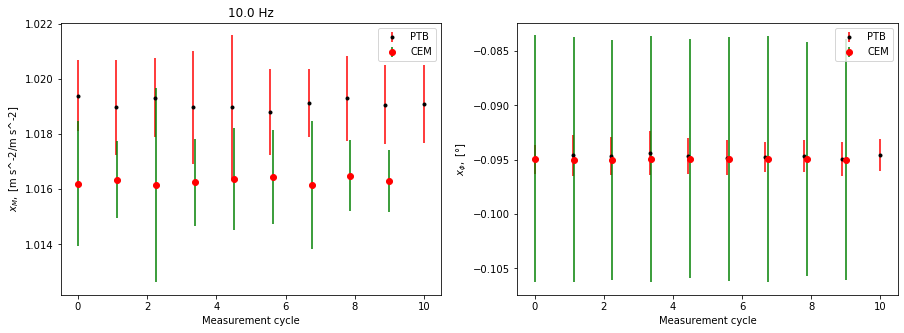

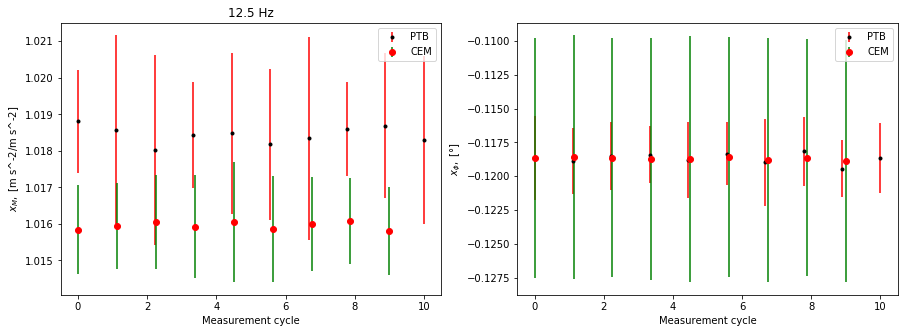

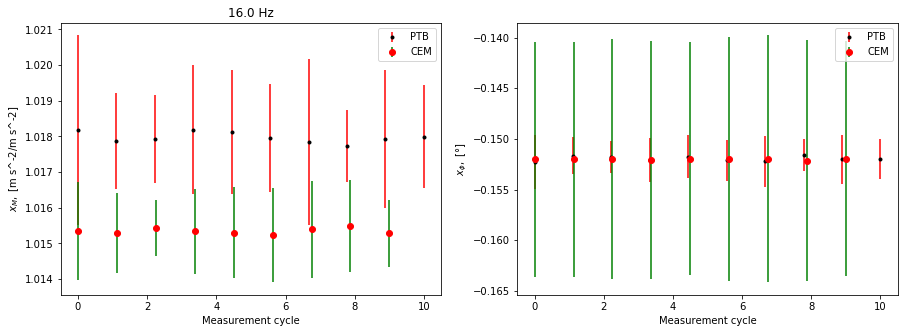

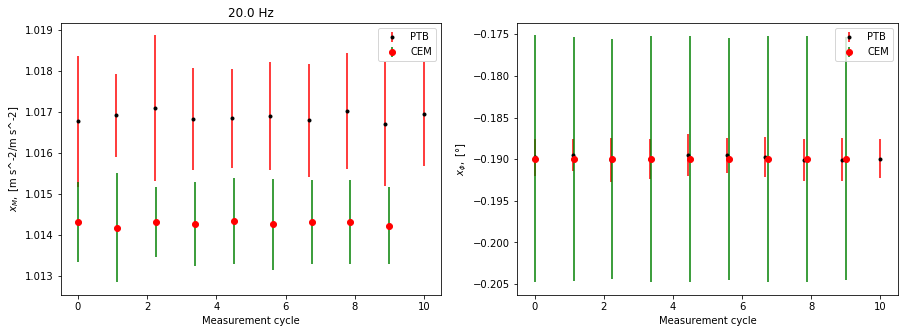

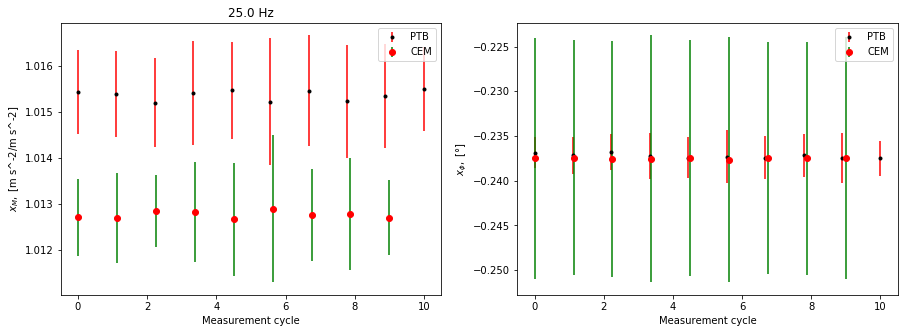

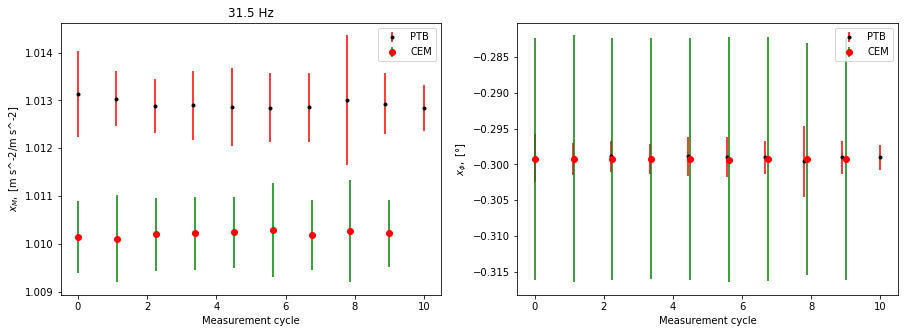

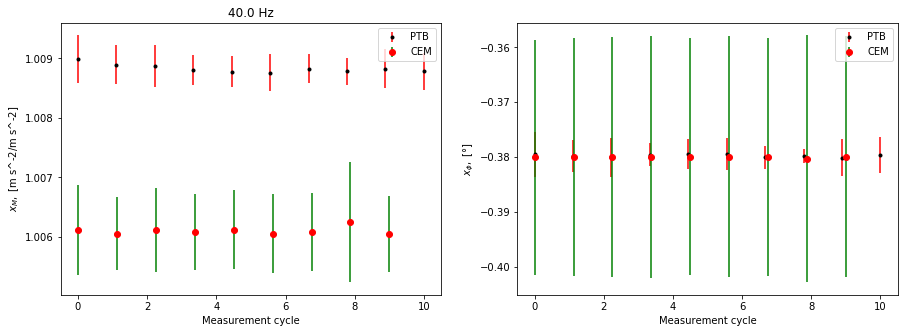

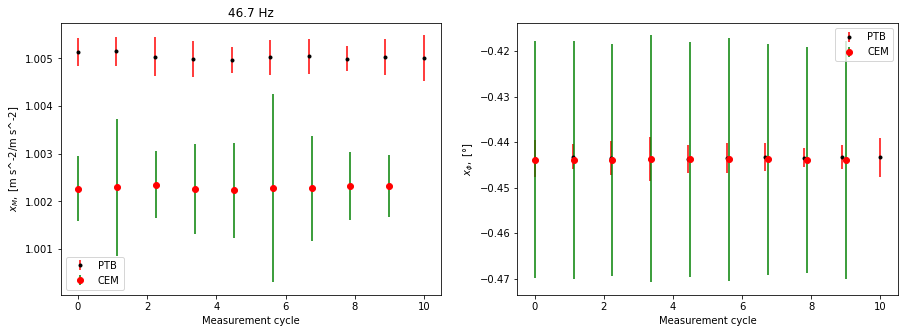

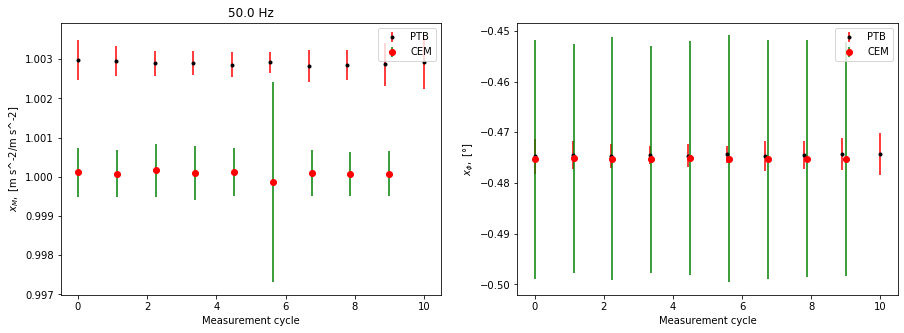

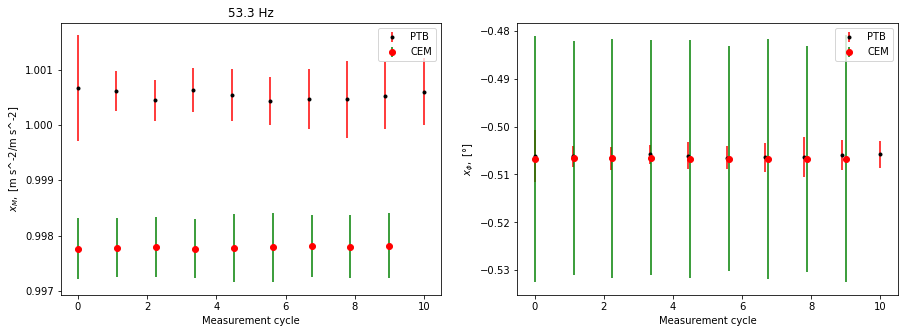

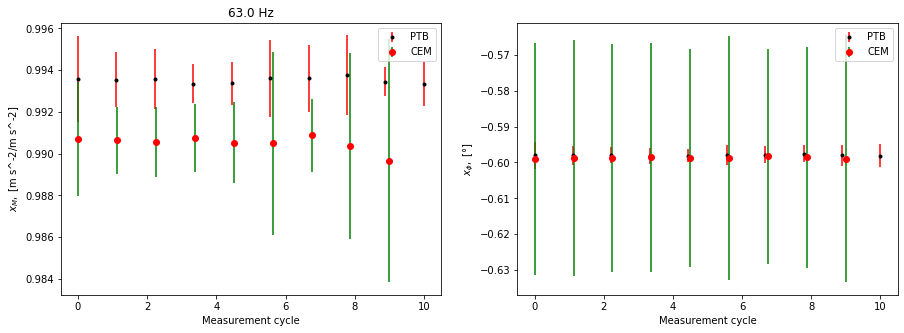

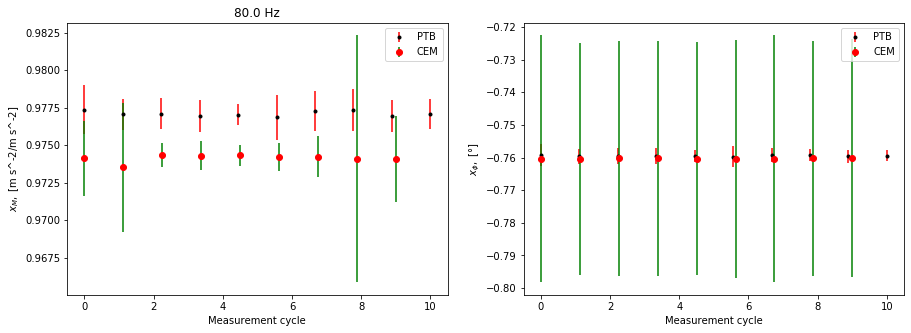

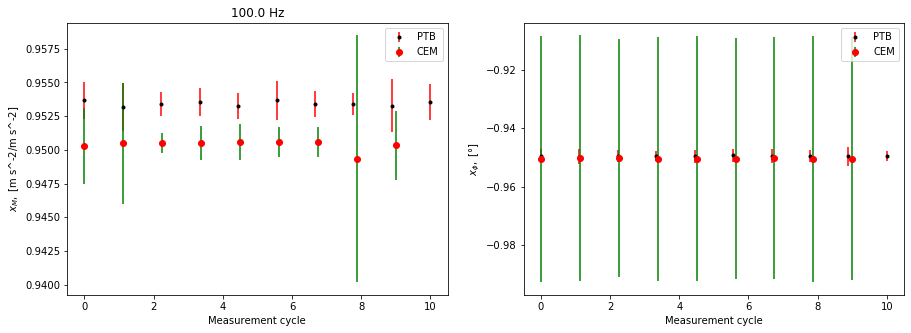

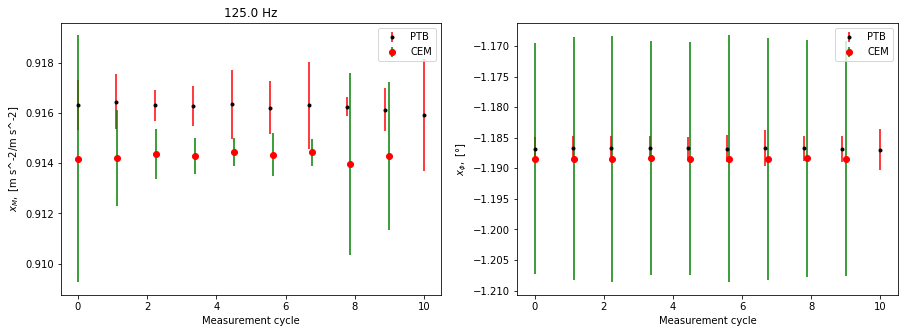

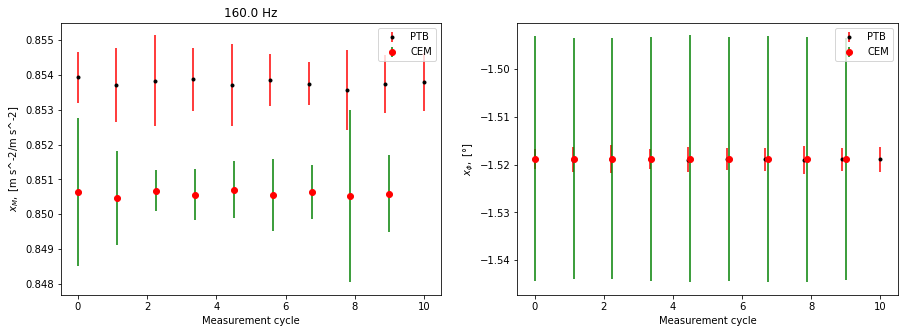

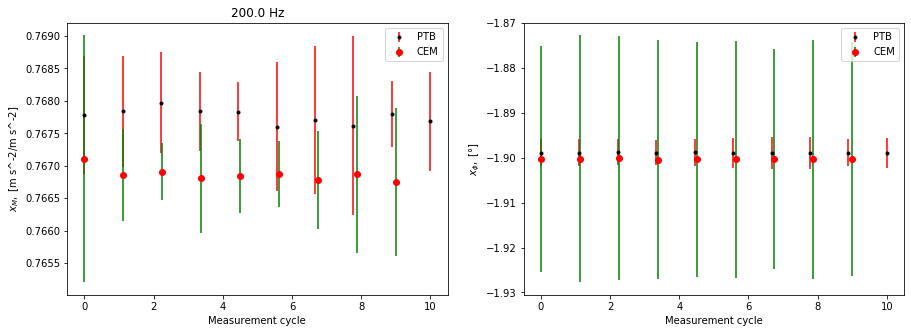

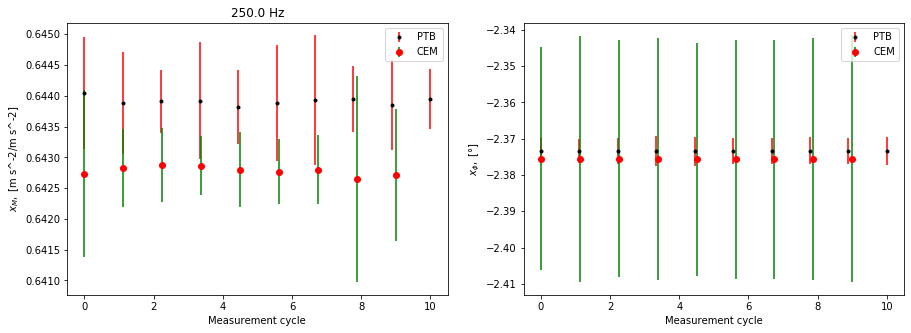

In [25]:
for val1,val2 in zip(PTB_separated_by_freq.values(),CEM_separated_by_freq_new.values()):  
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
 
    x = np.linspace(0,len(val1[q_names[1]]),len(val1[q_names[1]]))
    dy = val1[q_names[2]].values/2
    y = val1[q_names[1]].values
    plt.xlabel("Measurement cycle")
    plt.ylabel(r"$x_{M},$ [m s^-2/m s^-2]")
    plt.errorbar(x, y, yerr=dy, fmt='.k',ecolor='r',label="PTB")
    plt.title(str(val1[q_names[0]].values[0])+" Hz")
    
    x1 = np.linspace(0,len(val2[q_names[1]]),len(val2[q_names[1]]))
    plt.errorbar(x1,y=val2[q_names[1]].values,yerr =val2[q_names[2]].values/2,fmt='ro',ecolor='g',label="CEM")
    plt.legend()

    plt.subplot(1,2,2)
    x = np.linspace(0,len(val1[q_names[3]]),len(val1[q_names[3]]))
    dy = val1[q_names[4]].values/2
    y = val1[q_names[3]].values
    plt.xlabel("Measurement cycle")
    plt.ylabel(r"$x_{\phi},$ [°]")
    plt.errorbar(x, y, yerr=dy, fmt='.k',ecolor='r',label="PTB")
                         
    x1 = np.linspace(0,len(val2[q_names[3]]),len(val2[q_names[3]]))
    plt.errorbar(x1,y=val2[q_names[3]].values,yerr =val2[q_names[4]].values/2,fmt='ro',ecolor='g',label="CEM")
    plt.legend()
    
    #plt.subplot(1,3,3)
    #x = np.linspace(0,len(val1[q_names[6]]),len(val1[q_names[6]]))
    #dy = val1[q_names[7]].values/2
    #y = val1[q_names[6]].values
    #plt.xlabel("Measurement cycle")
    #plt.ylabel(r"$x_{Aexcit},$ [m s^-2/m s^-2]")
    #plt.errorbar(x, y, yerr=dy, fmt='.k',ecolor='r',label="PTB")
                          
    #x1 = np.linspace(0,len(val2[q_names[6]]),len(val2[q_names[6]]))
    #plt.errorbar(x1,y=val2[q_names[6]].values,yerr =val2[q_names[7]].values/2,fmt='ro',ecolor='b',label="CEM")
    plt.legend()
    plt.show()
    
    #the phase  - its timing information is not very susceptible, similar for PTB and CEM 
#Magnitude  - The difference between CEM and PTB is not the consequence of the different calibration systems. 
#sensor is differently behaving in Spain due to the influence of the tempeerature. Also, it is cheap and the axis can be different 
#cosine error

#Magnitude - manufacturer specifies 1% of tranfer coefficient deviation. Normally, higher uncertainty is stated because 
#due to the mounting influence. (statistically + extraunc)

Plots show that magnitude values measured by PTB setup are always higher than mangitude values measured by CEM. Magnitude ranges are completely distinguishable in a frequency range (20.0 - 53.3) Hz. 
Phase values are in a closer agreement, while uncertainties contribute to wider intervals for CEM at all frequencies. 

In [26]:
range_mag_PTB=range_mag_PTB.rename(columns={"Magntiude range, [m s^-2/m s^-2]":"Magntiude range, [m s^-2/m s^-2]-PTB"})
range_mag_CEM=range_mag_CEM.rename(columns={"Magntiude range, [m s^-2/m s^-2]":"Magntiude range, [m s^-2/m s^-2]-CEM"})
range_mag=pd.concat([range_mag_PTB, range_mag_CEM],axis=1)

range_ph_PTB=range_ph_PTB.rename(columns={"Phase range, [°]":"Phase range, [°]-PTB"})
range_ph_CEM=range_ph_CEM.rename(columns={"Phase range, [°]":"Phase range, [°]-CEM"})
range_ph=pd.concat([range_ph_PTB, range_ph_CEM],axis=1)


In [27]:
def highlight_max(s, props=''):
    return np.where(s == np.nanmax(s.values), props, '')

In [28]:
# create output widgets
widget1 = widgets.Output()
widget2 = widgets.Output()


with widget1:
    display.display(range_mag.style.apply(highlight_max,axis=1,props='color:white;background-color:pink'))

with widget2:
    display.display(range_ph.style.apply(highlight_max,axis=1,props='color:white;background-color:pink')
)
  #add some CSS styles to distribute free space
box_layout = Layout(display='flex',
                    flex_flow='row',
                    justify_content='space-around',
                    width='auto'
                   )
    
# create Horisontal Box container
hbox = widgets.HBox([widget1, widget2], layout=box_layout)

# render hbox
hbox

Tables show that observation of magnitudes is dependable on the frequency and sometimes are higher for PTB, whereas sometimes for CEM. Significant ranges are:
<br> (63.0 - 250.0)Hz - CEM setup shows higher uncertainties than PTB
<br> (40.0 - 50.0)Hz - CEM setup shows higher uncertainties than PTB
<br> (12.5 - 20.0)Hz - PTB setup shows higher uncertainties than CEM.

## 3.2 Coefficient of variation

The coefficient of variation (CV) is a statistical measure of the dispersion of data points in a data series around the mean. The coefficient of variation represents the ratio of the standard deviation to the mean, and it is a useful statistic for comparing the degree of variation from one data series to another, even if the means are drastically different from one another.[1]

For each experiment, CV in percentages is calculated as:
$$CV={\frac {\sigma _{i}}{\bar {x_{i}}}} *100 $$
,where x represents magnitude, phase, and excitation amplituded and $\sigma$ corresponds to the assigned uncertainty values.

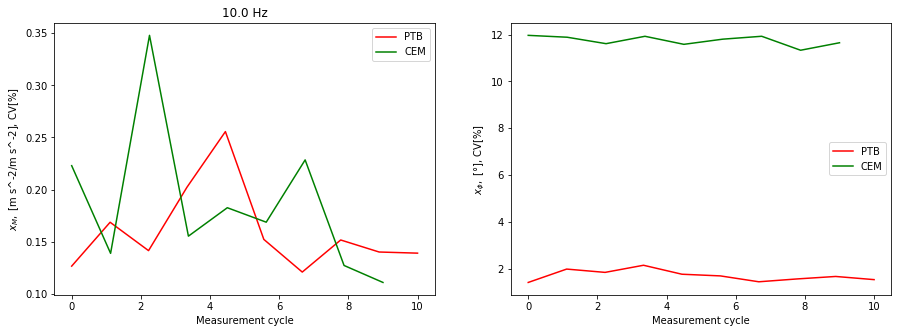

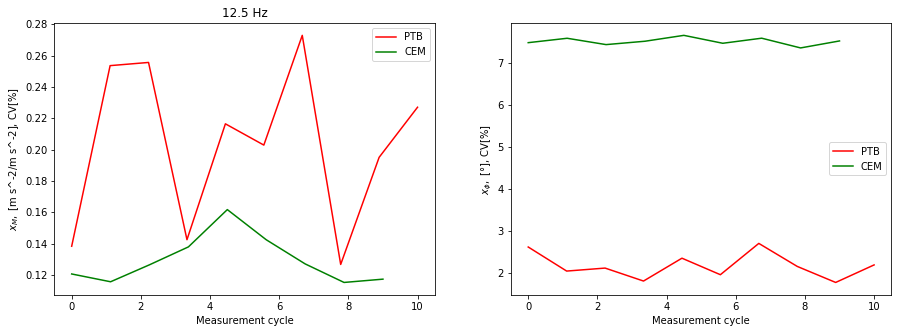

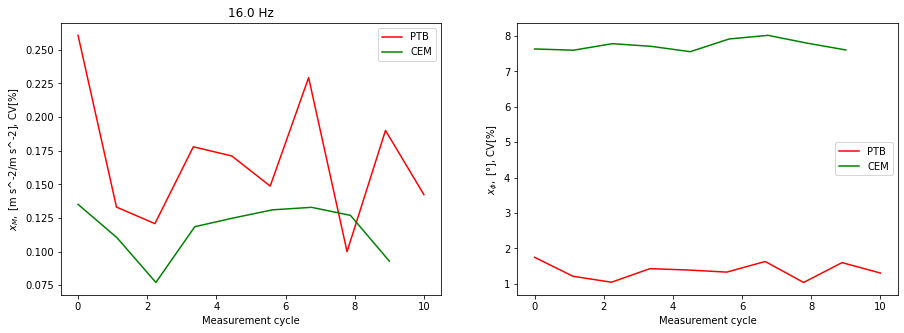

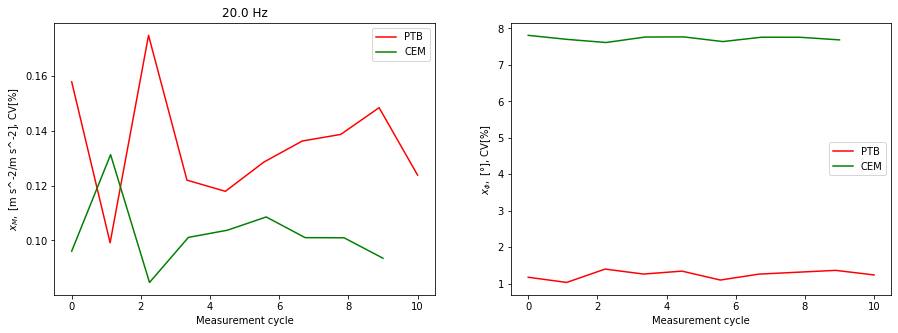

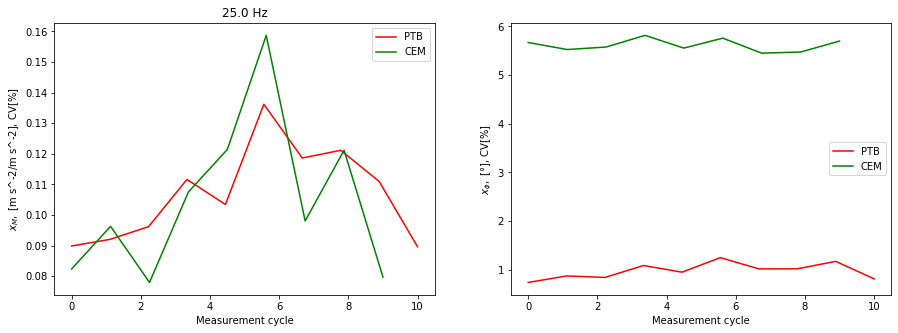

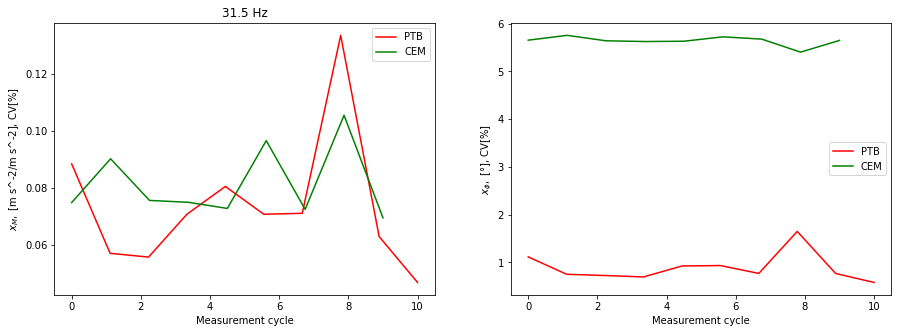

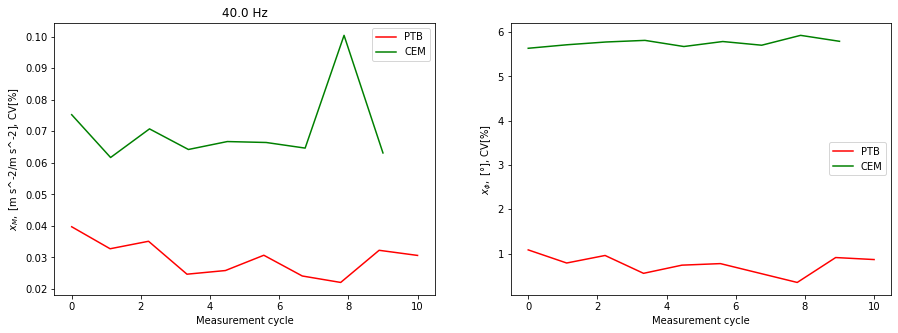

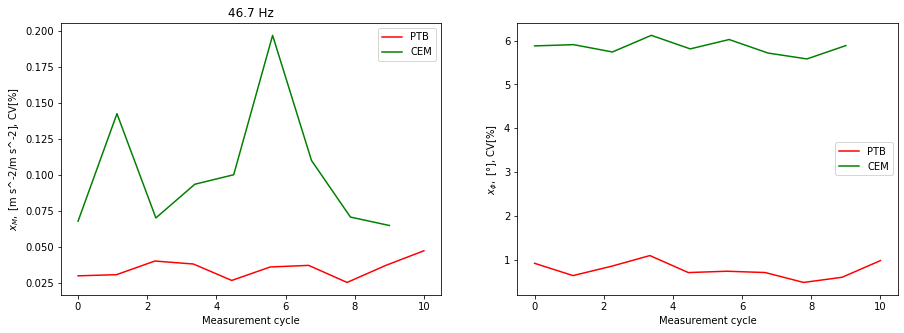

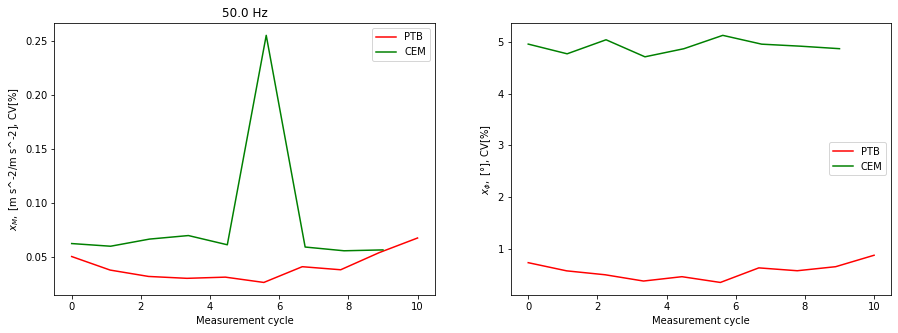

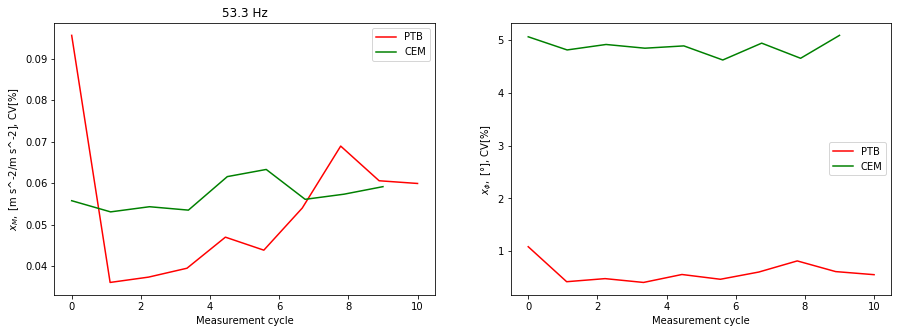

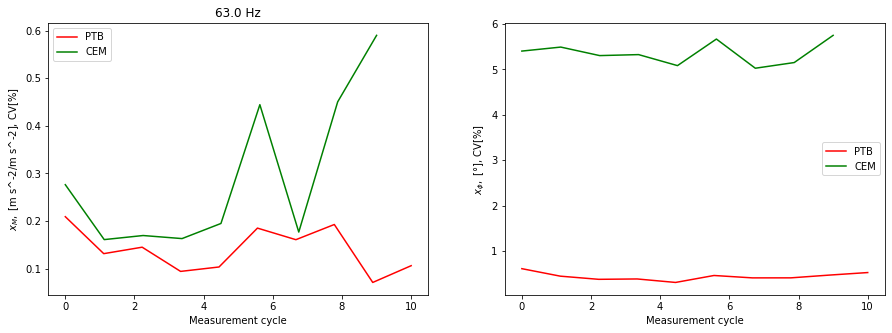

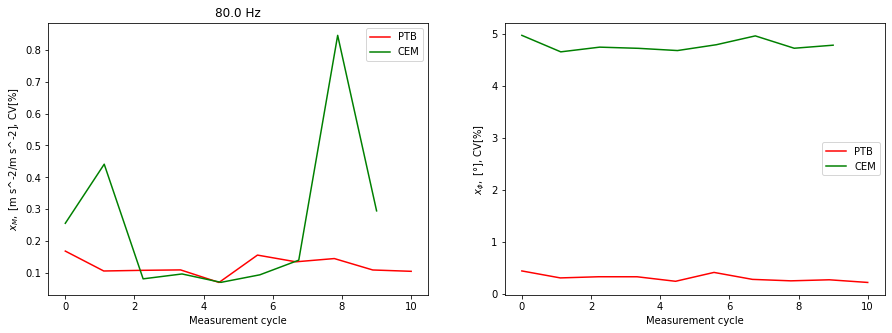

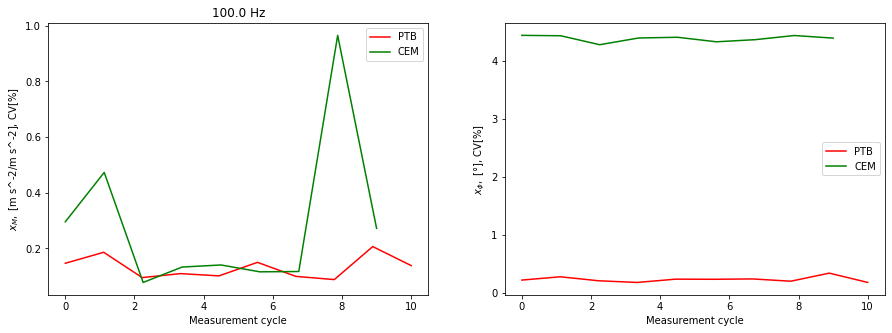

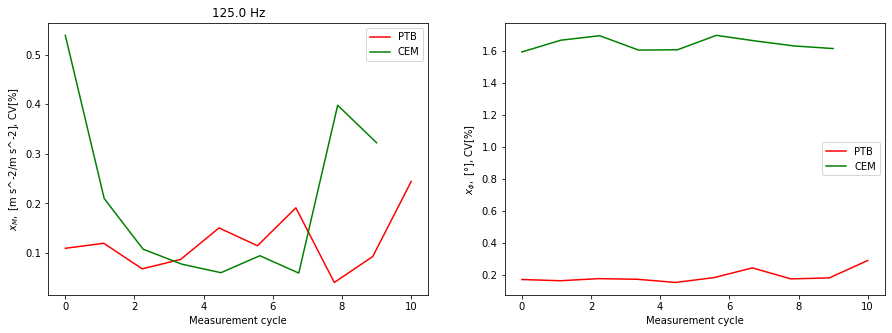

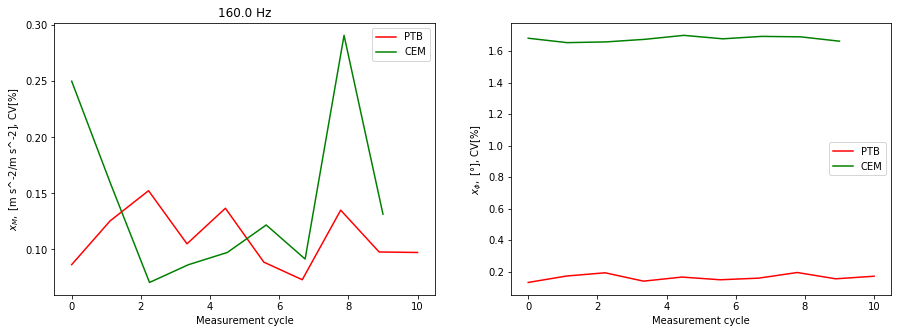

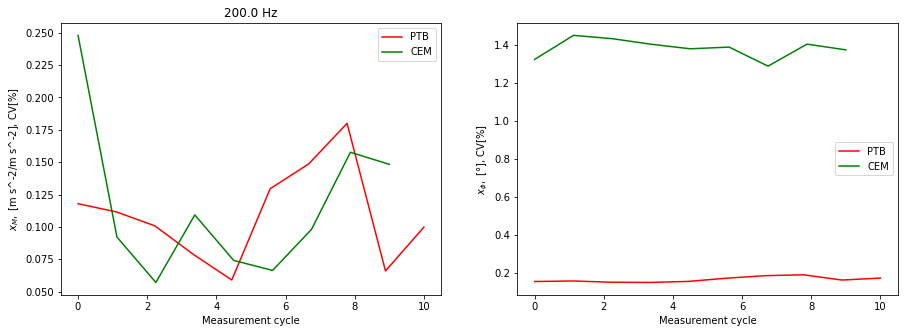

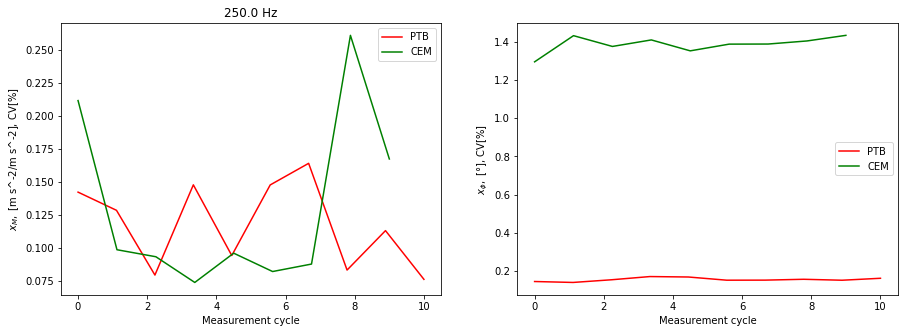

In [29]:
for val1,val2 in zip(PTB_separated_by_freq.values(),CEM_separated_by_freq_new.values()):  
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
 
    x = np.linspace(0,len(val1[q_names[1]]),len(val1[q_names[1]]))
    y_coef = ((val1[q_names[2]].values/2)/np.abs(val1[q_names[1]].values))*100
    plt.xlabel("Measurement cycle")
    plt.ylabel(r"$x_{M},$ [m s^-2/m s^-2], CV[%]")
    plt.plot(x, y_coef,color='r',label="PTB")
    plt.title(str(val1[q_names[0]].values[0])+" Hz")
    x1 = np.linspace(0,len(val2[q_names[1]]),len(val2[q_names[1]])) 
    plt.plot(x1,((val2[q_names[2]].values/2)/np.abs(val2[q_names[1]].values))*100,color='g',label="CEM")
    plt.legend()

    plt.subplot(1,2,2)
    x = np.linspace(0,len(val1[q_names[3]]),len(val1[q_names[3]]))
    y = ((val1[q_names[4]].values/2)/np.abs(val1[q_names[3]].values))*100
    plt.xlabel("Measurement cycle")
    plt.ylabel(r"$x_{\phi},$ [°], CV[%]")
    plt.plot(x, y,color='r',label="PTB")
    x1 = np.linspace(0,len(val2[q_names[4]]),len(val2[q_names[4]]))                      
    plt.plot(x1,((val2[q_names[4]].values/2)/np.abs(val2[q_names[3]].values))*100,color='g',label="CEM")
    plt.legend()
    
    #plt.subplot(1,3,3)
    #x = np.linspace(0,len(val1[q_names[6]]),len(val1[q_names[6]]))
    #y = (val1[q_names[7]].values/np.abs(val1[q_names[6]].values))*100
    #plt.xlabel("Measurement cycle")
    #plt.ylabel(r"$x_{Aexcit},$ [m s^-2/m s^-2], CV[%]")
    #plt.plot(x, y, color='r',label="PTB")
                          
    #x1 = np.linspace(0,len(val2[q_names[6]]),len(val2[q_names[6]]))
    #plt.plot(x1,(val2[q_names[7]].values/np.abs(val2[q_names[6]].values))*100,color='b',label="CEM")
    plt.show()
    

Mean variation coefficients are calculated as averages of all CVs at a given frequency:

$${\bar {CV}={\frac{\sum _{i=1}^{n}CV _{i}}{n}}}$$
,where n represents the number of experiments at a specific frequency.

In [30]:
def calculate_mean_variation_coefficient(dictionary):
    variation_coef=np.empty((len(dictionary),3))
    for val1,i in zip(dictionary.values(),range(len(dictionary))):  
        variation_coef[i,0]=(((val1[q_names[2]].values/2)/np.abs(val1[q_names[1]].values))*100).mean()
        variation_coef[i,1]=(((val1[q_names[4]].values/2)/np.abs(val1[q_names[3]].values))*100).mean()
        variation_coef[i,2]=(((val1[q_names[7]].values/2)/np.abs(val1[q_names[6]].values))*100).mean()
    return variation_coef

In [31]:
variation_coef_PTB=calculate_mean_variation_coefficient((PTB_separated_by_freq))
variation_coef_CEM=calculate_mean_variation_coefficient((CEM_separated_by_freq_new))

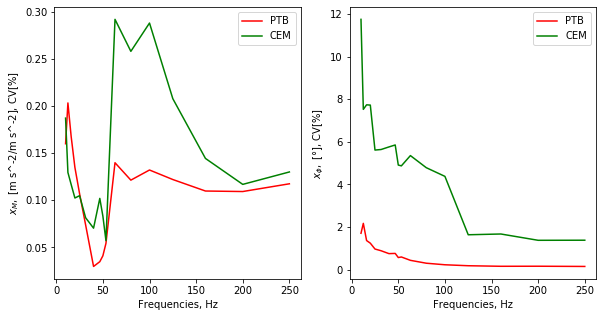

In [32]:
    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1)
    list_of_freq=[10,12.5,16,20,25,31.5,40,46.7,50,53.3,63,80,100,125,160,200,250]
    x = np.asarray(list_of_freq)
    y_coef = variation_coef_PTB[:,0]
    
    plt.xlabel("Frequencies, Hz")
    plt.ylabel(r"$x_{M},$ [m s^-2/m s^-2], CV[%]")
    plt.plot(x, y_coef,color='r',label="PTB")
    plt.plot(x,variation_coef_CEM[:,0],color='g',label="CEM")
    plt.legend()

    plt.subplot(1,3,2)
    x = np.asarray(list_of_freq)
    plt.xlabel("Frequencies, Hz")
    plt.ylabel(r"$x_{\phi},$ [°], CV[%]")
    plt.plot(x, variation_coef_PTB[:,1],color='r',label="PTB")
    plt.plot(x,variation_coef_CEM[:,1],color='g',label="CEM")
    plt.legend()
    
    #plt.subplot(1,3,3)
    #x = np.asarray(list_of_freq)
    #plt.xlabel("Frequencies, Hz")
    #plt.ylabel(r"$x_{Aexcit},$ [m s^-2/m s^-2], CV[%]")
    #plt.plot(x, variation_coef_PTB[:,2], color='r',label="PTB")
    #plt.plot(x, variation_coef_CEM[:,2],color='b',label="CEM")
    #plt.legend() 
    #plt.show()
    

The averaged coefficient of variation for PTB's setup than for CEM's. When observing the magnitude data, the lowest coefficient of variation for both laboratories correspond to the calibration points where lowest uncertainties are detected. The trend of variation is similar for both laboratories. CEM has significantly higher coefficient of variation at all calibration points in a range (63.0 - 200.0) Hz.
When observing phase data, coefficient of variation is always higher for CEM than for PTB. The variation for both laboratories is decreasing from 125.0 Hz. However, in a lower calibration points, some fluctuations are visible.

## 3.3  The extraction of temperature data

As mentioned above, the magnitude values measured by PTB setup are always higher than for CEM. This might be a consequence of environmental conditions. Therefore, the temperature data is extracted in order to assess the potential correlatiob between temperature and magnitude. 

In [33]:
def extract_temp (filename, sensor_index):
    
    with h5py.File(filename,'r') as f:
            base_items=list(f.items())
            rawtransfer=f.get("EXPERIMENTS")
            rawtransfer_items=list(rawtransfer.items())
            subgroup=rawtransfer.get("/EXPERIMENTS/Sine excitation/")
            subgroup_items=list(subgroup.items())
            temp=[None]*(len(subgroup_items))

            for i,val in enumerate(subgroup_items):
                subgroup1=rawtransfer.get("/EXPERIMENTS/Sine excitation/00"+"{0:03}".format(i)+"_Sine_Excitation/"+sensor_index+"_MPU_9250/Temperature/")
                subgroup1=np.array(subgroup1.get("SinPOpt"))
                temp[i]=subgroup1[0,1]
            return temp

In [34]:
temp_PTB = extract_temp('MPU9250PTB_v2.hdf5',"0x1fe40000")
temp_CEM = extract_temp('MPU9250CEM_v2.hdf5',"0xbccb0000")

In [35]:
temp_PTB=pd.DataFrame(temp_PTB,columns=["Temperature [°C]"])
temp_PTB["Frequency [Hz]"]=whole_dataset_PTB["Frequency [Hz]"]

In [36]:
temp_CEM=pd.DataFrame(temp_CEM,columns=["Temperature [°C]"])
temp_CEM["Frequency [Hz]"]=whole_dataset_CEM["Frequency [Hz]"]

In [37]:
delete_rows=[]

for k in range(0,171,19):
    i=k
    j=k+1
    delete_rows.append(i)
    delete_rows.append(j)
temp_CEM_new=temp_CEM.drop(axis=0,index=delete_rows)

## 3.4 Additional analysis of magnitude and phase data 

For the further analysis, data is sorted by frequency in ascending order. Note that this analysis does not take uncertainties into account.

In [38]:
#this is for analysis in Excel
def sort_values(dataset):
    dataset=dataset.sort_values("Frequency [Hz]", ascending=True)
    return dataset

In [39]:
whole_dataset_PTB=sort_values(whole_dataset_PTB)
whole_dataset_CEM=sort_values(whole_dataset_CEM_new)

In [40]:
whole_dataset_PTB.head(2)

Frequency [Hz]  $x_{M},$ [m s^-2/m s^-2]  $U_{M},$ [m s^-2/m s^-2]  \
0             10.0                  1.019399                  0.002580   
51            10.0                  1.018972                  0.004122   

    $x_{\phi},$ [°]  $U_{\phi},$ [°]  Excitation_freq [Hz]  \
0         -0.094967         0.002696                  10.0   
51        -0.094405         0.004065                  10.0   

    $x_{Aexcit},$ [m s^-2/m s^-2]  $U_{Aexcit},$ [m s^-2/m s^-2]  
0                           2.739                       0.000548  
51                          2.749                       0.000550

In [41]:
whole_dataset_CEM.head(2)

Frequency [Hz]  $x_{M},$ [m s^-2/m s^-2]  $U_{M},$ [m s^-2/m s^-2]  \
2              10.0                  1.016208                  0.004531   
135            10.0                  1.016488                  0.002586   

     $x_{\phi},$ [°]  $U_{\phi},$ [°]  Excitation_freq [Hz]  \
2          -0.094907         0.022714                  10.0   
135        -0.094932         0.021514                  10.0   

     $x_{Aexcit},$ [m s^-2/m s^-2]  $U_{Aexcit},$ [m s^-2/m s^-2]  
2                           2.7543                       0.002754  
135                         2.7605                       0.002760

In order to plot magnitude and phase data in a relation to the frequency values in linear and logarithmic scale, the mean values of all experiments are calculated and stored in variables: *whole_dataset_PTB_groupby* and *whole_dataset_CEM_groupby*  

In [42]:
whole_dataset_PTB_groupby=whole_dataset_PTB.groupby(['Frequency [Hz]']).mean()
whole_dataset_CEM_groupby=whole_dataset_CEM.groupby(['Frequency [Hz]']).mean()

In [43]:
whole_dataset_PTB["Lab"]="PTB"
whole_dataset_CEM["Lab"]="CEM"
whole_dataset_PTB_groupby["Lab"]="PTB"
whole_dataset_CEM_groupby["Lab"]="CEM"

In [44]:
result = pd.concat([whole_dataset_PTB,whole_dataset_CEM])
result_groupby= pd.concat([whole_dataset_PTB_groupby,whole_dataset_CEM_groupby])

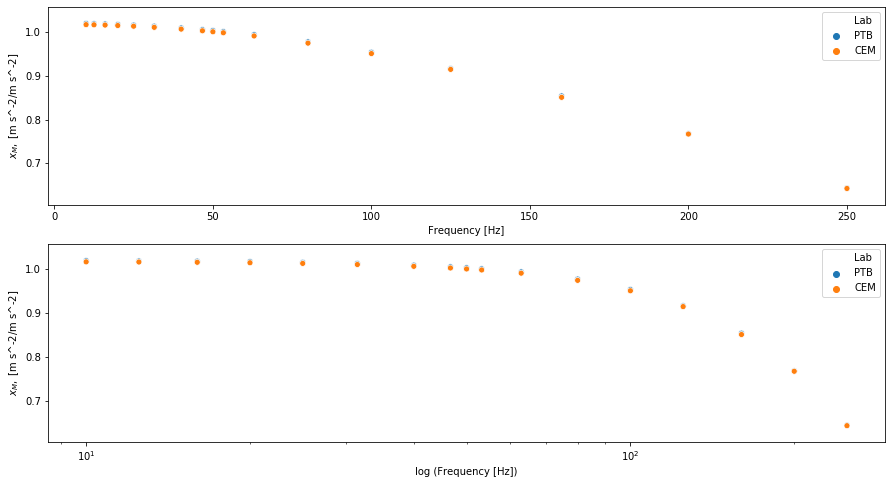

In [45]:


f,ax=plt.subplots(nrows=2,ncols=1,figsize=(15,8))
sns.scatterplot(x=result_groupby.index, y=r"$x_{M},$ [m s^-2/m s^-2]", hue="Lab",ax=ax[0],
                    data=result_groupby) #palette="Set2")
sns.scatterplot(x=result_groupby.index, y=r"$x_{M},$ [m s^-2/m s^-2]", hue="Lab",ax=ax[1],
                    data=result_groupby )
ax[1].set_xscale("log")
ax[1].set_xlabel("log (Frequency [Hz])")
plt.show()

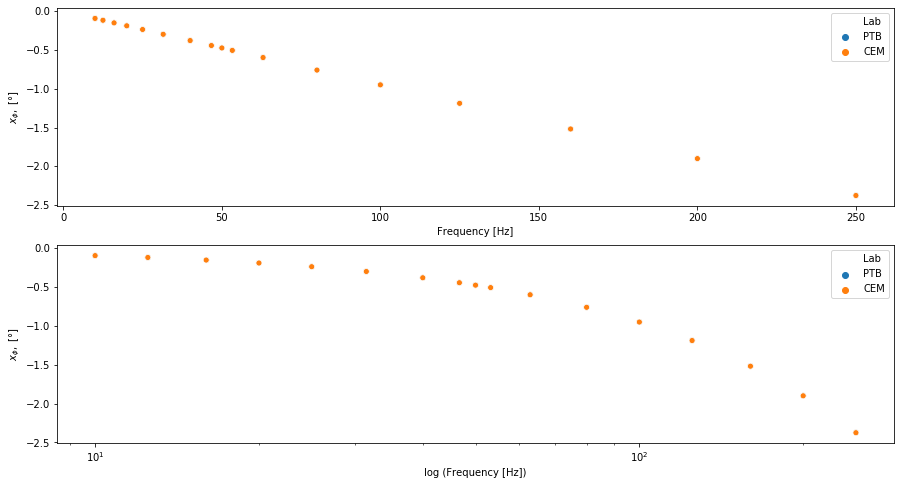

In [46]:
f,ax=plt.subplots(nrows=2,ncols=1,figsize=(15,8))
sns.scatterplot(x=result_groupby.index, y=r"$x_{\phi},$ [°]", hue="Lab",ax=ax[0],
                    data=result_groupby) #palette="Set2")
sns.scatterplot(x=result_groupby.index, y=r"$x_{\phi},$ [°]", hue="Lab",ax=ax[1],
                    data=result_groupby )
ax[1].set_xscale("log")
ax[1].set_xlabel("log (Frequency [Hz])")
plt.show()

Violin plots are shown for magnitudes and phases at different frequencies. <b>These plots do not include uncertainties. A short explanation of a violin plot is as follows:

A violin plot is a hybrid of a box plot and a kernel density plot, which shows peaks in the data.

The anatomy of a violin plot have many of the same summary statistics as box plots:
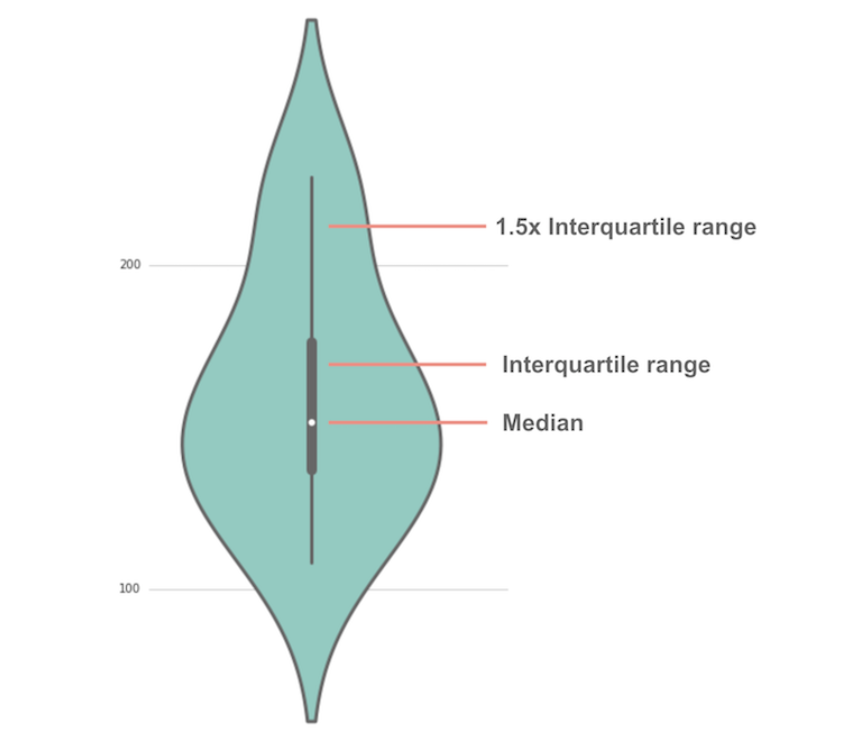
<br>-the white dot represents the median
<br>-the thick gray bar in the center represents the interquartile range
<br>-the thin gray line represents the rest of the distribution, except for points that are determined to be “outliers” using a method that is a function of the interquartile range.

On each side of the gray line is a kernel density estimation to show the distribution shape of the data. Wider sections of the violin plot represent a higher probability that members of the population will take on the given value; the skinnier sections represent a lower probability.
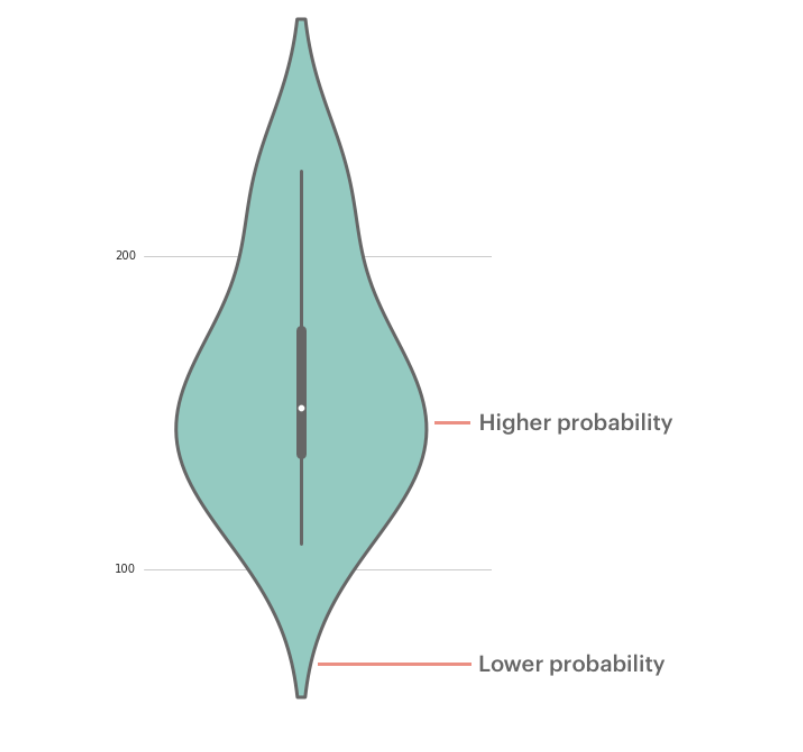



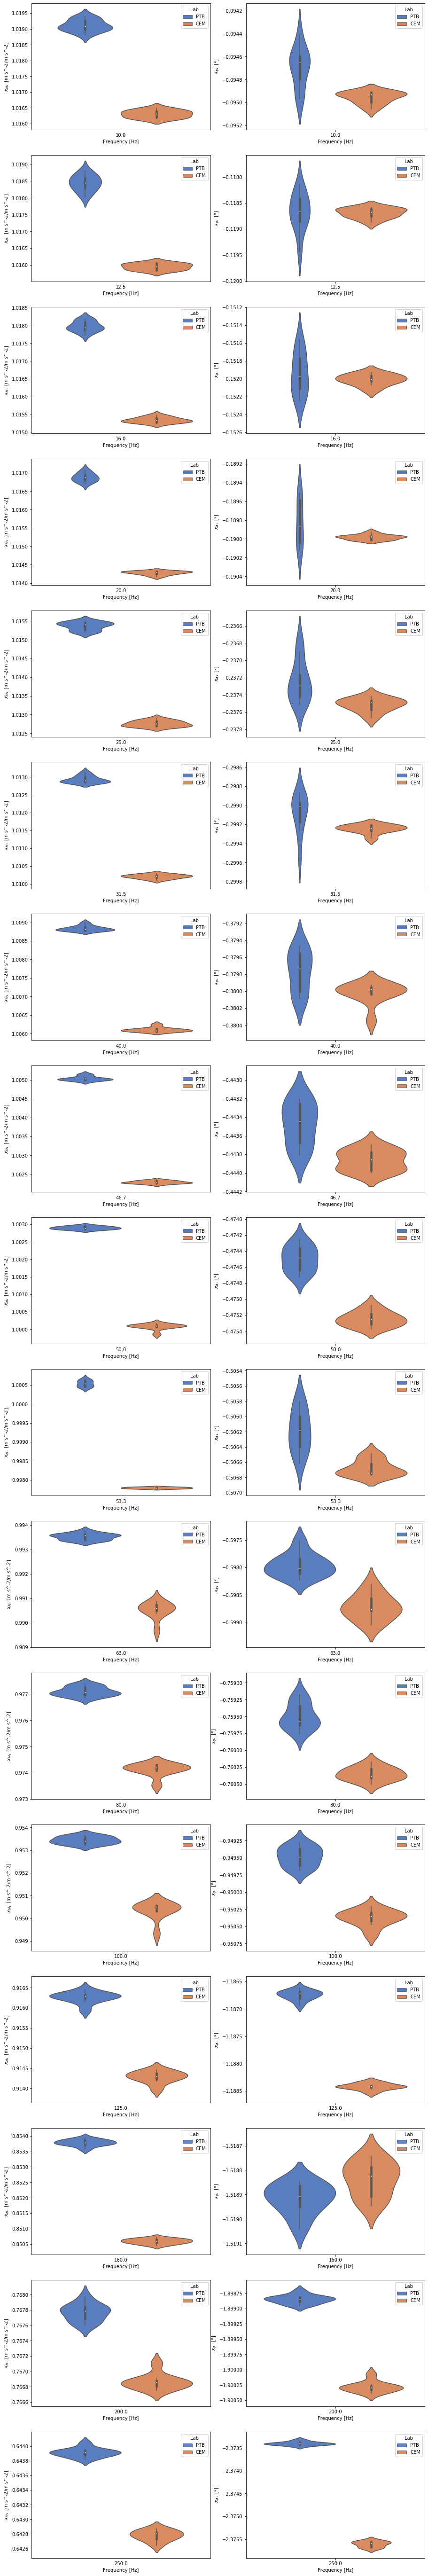

In [47]:
list_freq=result["Frequency [Hz]"].unique()
f,ax=plt.subplots(nrows=len(list_freq),ncols=2,figsize=(15,100))
for i,val in enumerate(list_freq):
    
    result1=result.loc[result["Frequency [Hz]"].values==val,:]
    
    sns.violinplot(x="Frequency [Hz]", y=r"$x_{M},$ [m s^-2/m s^-2]", hue="Lab",ax=ax[i,0],
                    data=result1, palette="muted", split=False,orient="v")
    sns.violinplot(x="Frequency [Hz]", y=r"$x_{\phi},$ [°]", hue="Lab",ax=ax[i,1],
                    data=result1, palette="muted", split=False,orient="v")

At some frequencies distribution of quantities of interest is multimodal and at is near to normal, left or right skewed. 

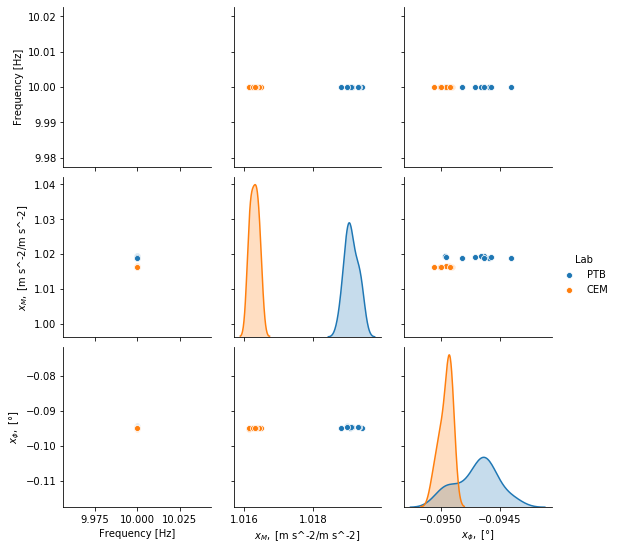

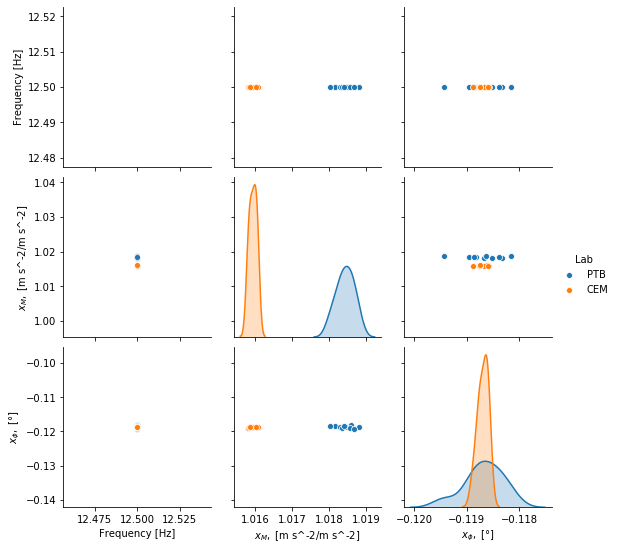

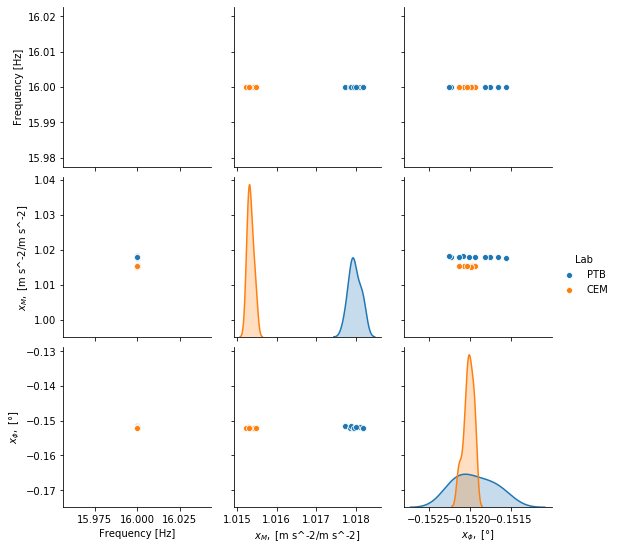

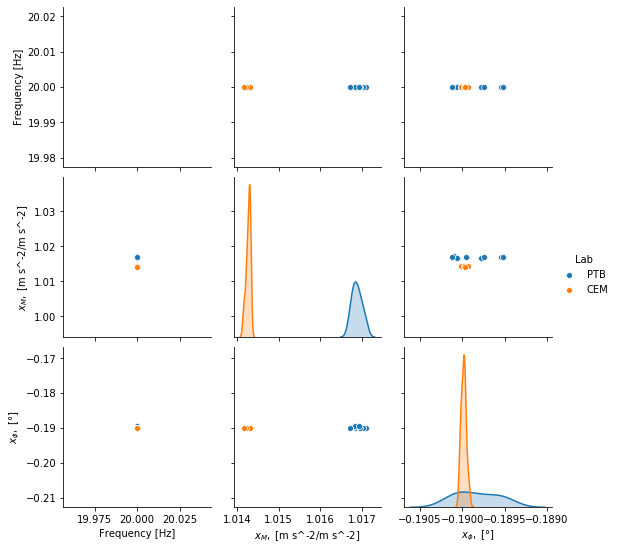

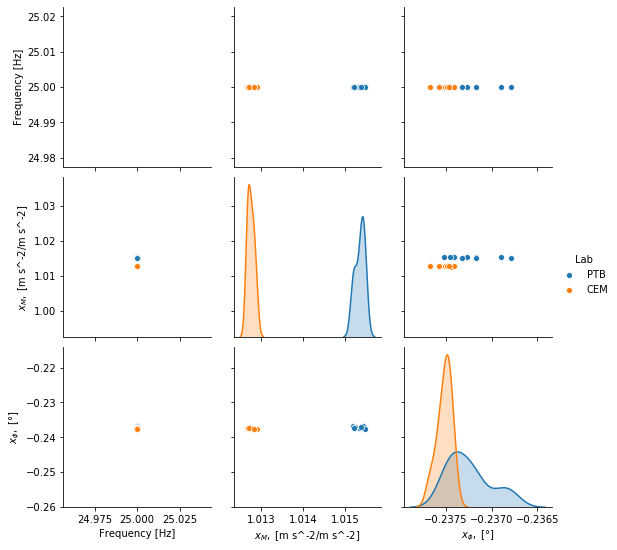

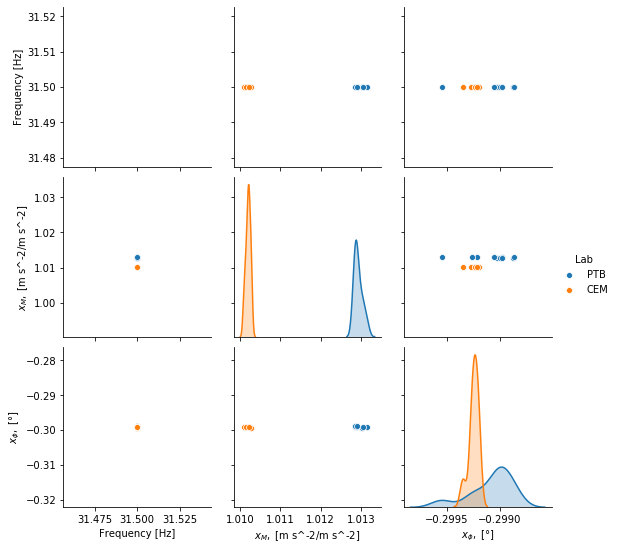

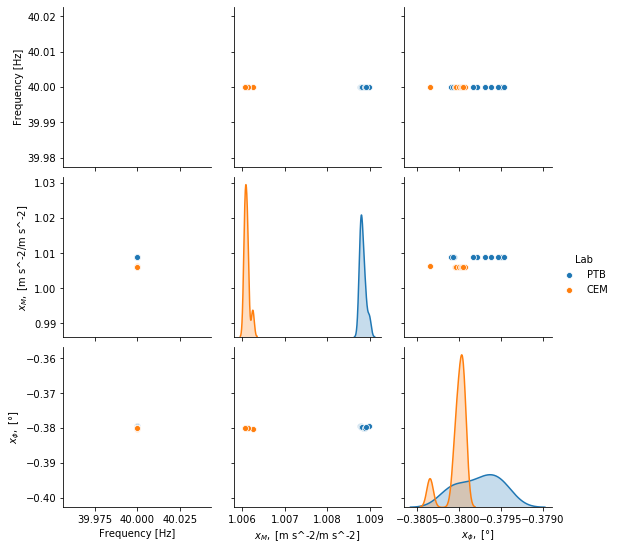

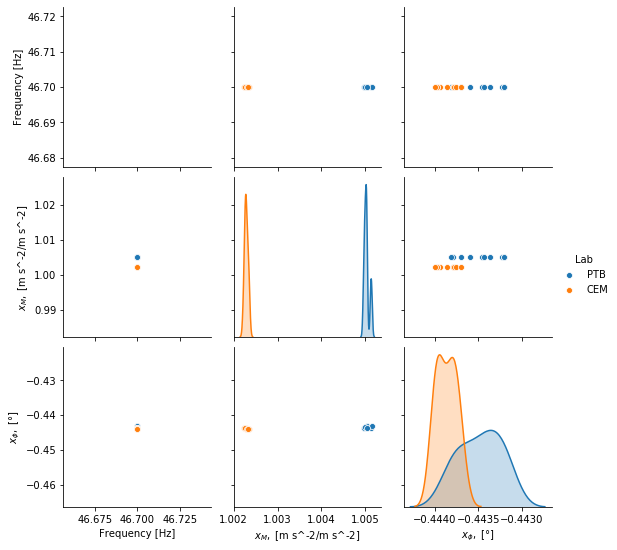

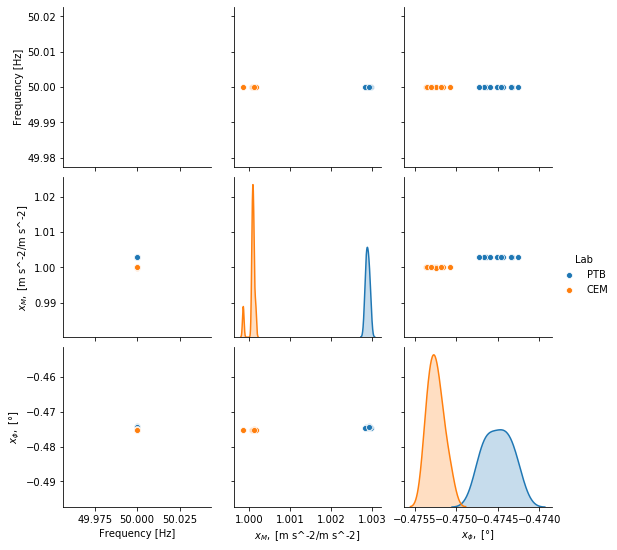

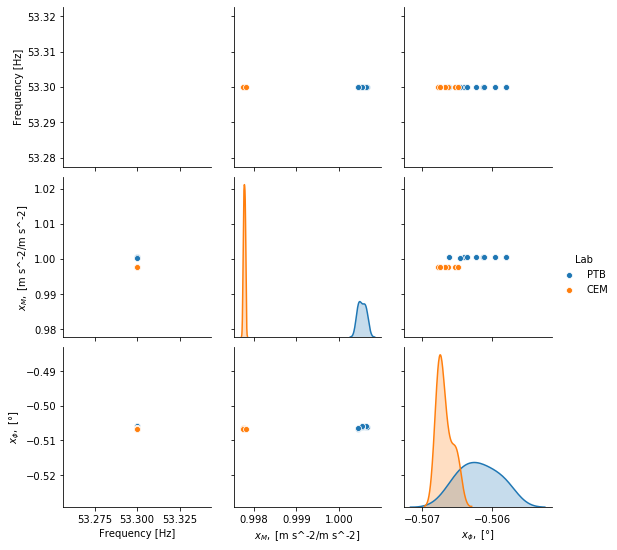

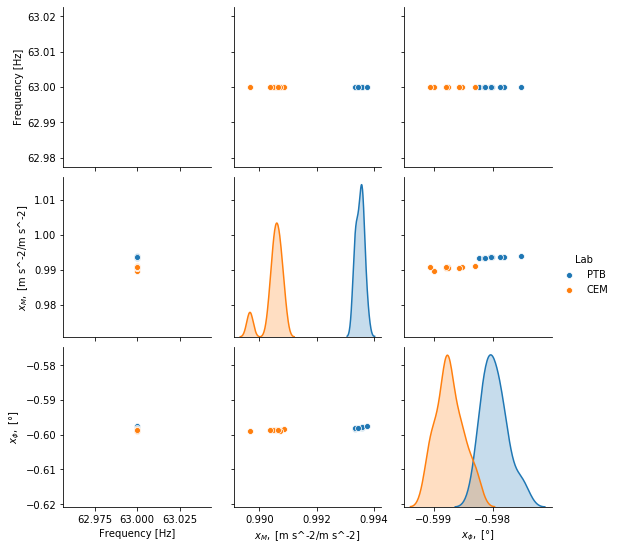

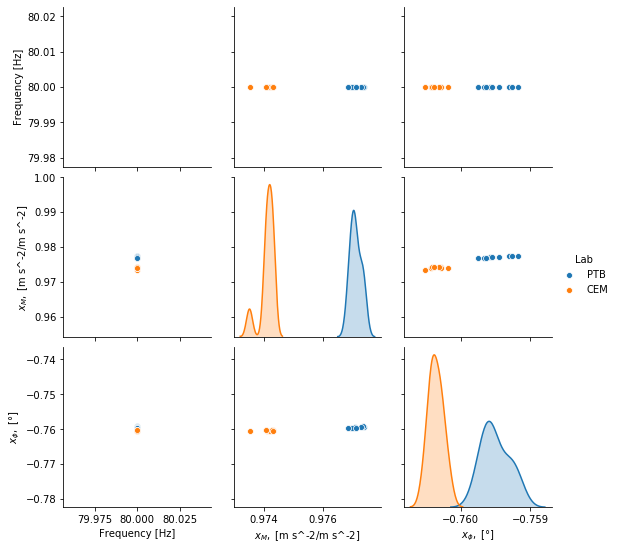

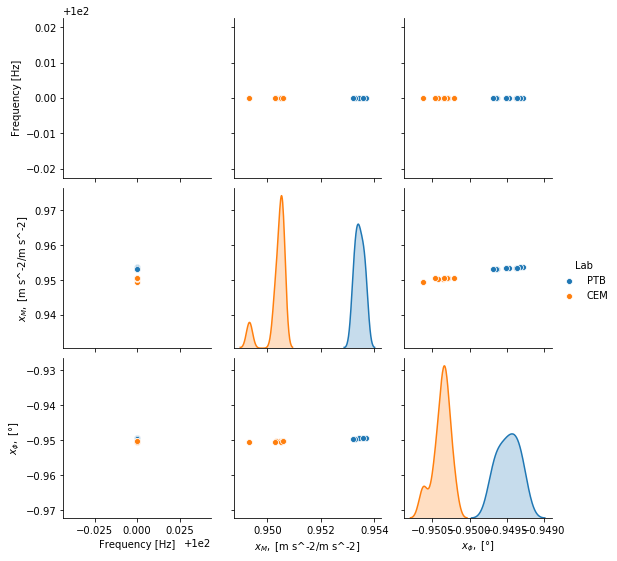

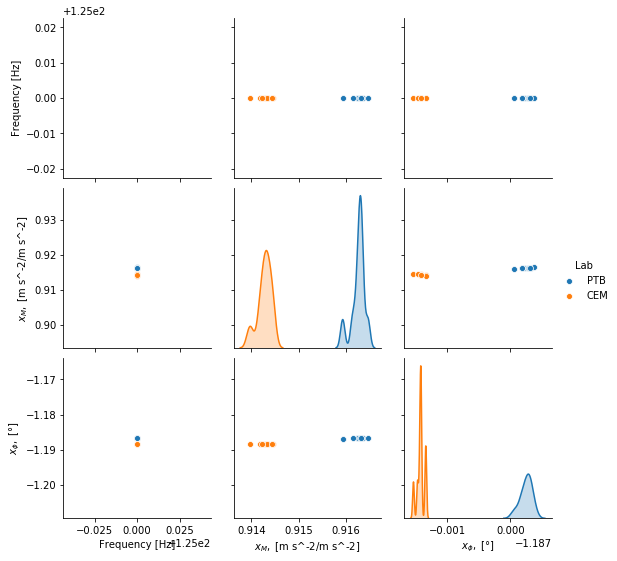

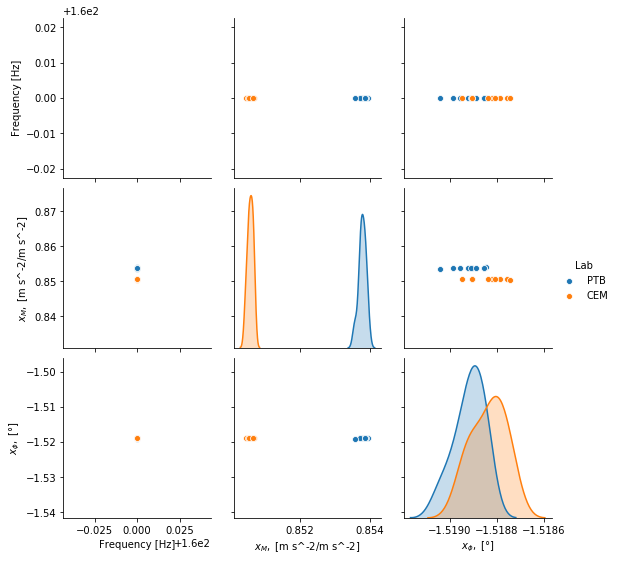

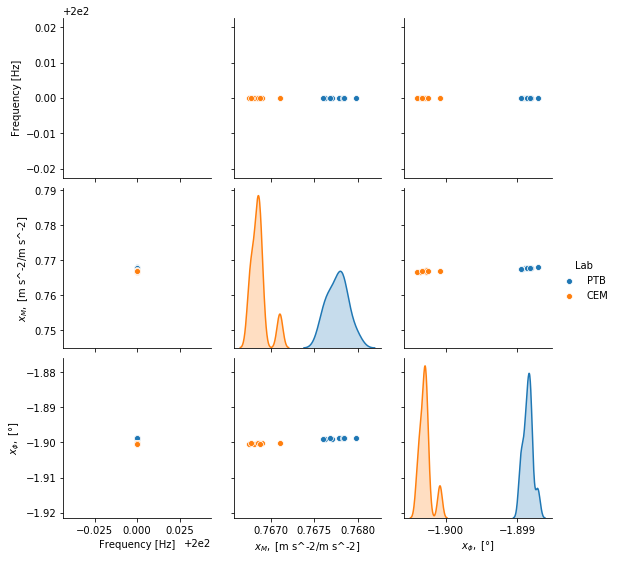

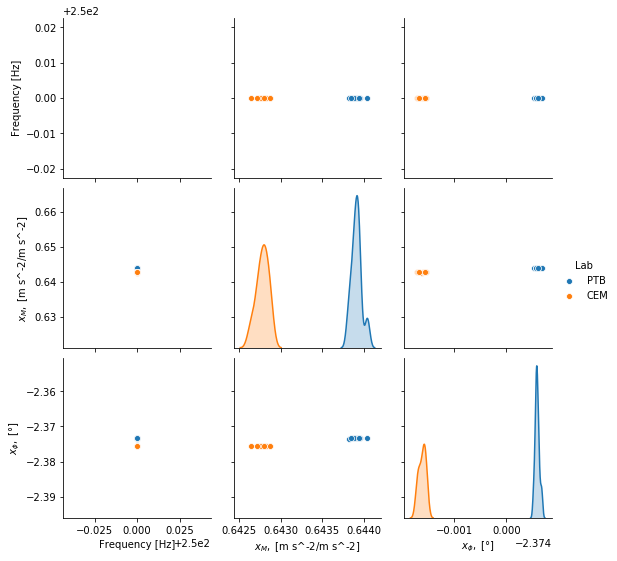

In [48]:

warnings.filterwarnings('ignore')
for i,val in enumerate(list_freq):
    
    result1=result.loc[result["Frequency [Hz]"].values==val,:]
    result2=result1[['Frequency [Hz]', r"$x_{M},$ [m s^-2/m s^-2]",r"$x_{\phi},$ [°]","Lab"]]
    sns.pairplot(result2, hue="Lab")
    

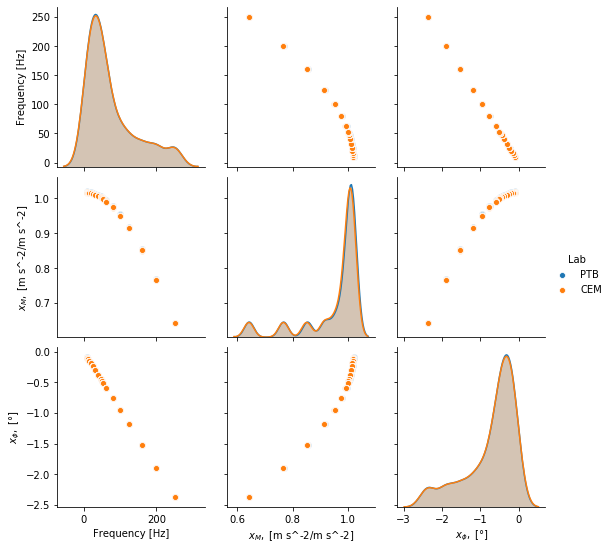

In [49]:
result2=result[['Frequency [Hz]',r"$x_{M},$ [m s^-2/m s^-2]",r"$x_{\phi},$ [°]","Lab"]]
sns.pairplot(result2, hue="Lab")

## 3.5 The effect of environmental temperature on magnitude and phase

The initial insight in data shows that measurements in PTB were performed on a higher environmental temperature than in CEM. 

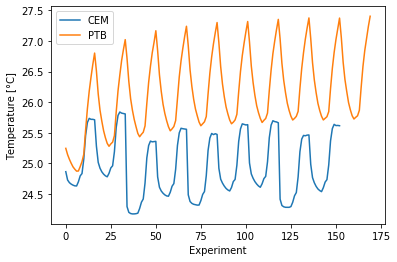

In [50]:
#takes some time tu run because of a huge number of points
ax = plt.axes()
sns.lineplot(x=np.arange(len(temp_CEM_new)), y=temp_CEM_new["Temperature [°C]"].values,ax=ax, label="CEM")
sns.lineplot(x=np.arange(len(temp_PTB)), y=temp_PTB["Temperature [°C]"].values,ax=ax, label="PTB")
plt.xlabel("Experiment")
plt.ylabel("Temperature [°C]")
plt.legend()                         
plt.show()

In [51]:
temp_2_PTB=pd.concat([whole_dataset_PTB,temp_PTB["Temperature [°C]"]],axis=1)
temp_2_CEM=pd.concat([whole_dataset_CEM_new,temp_CEM_new["Temperature [°C]"]],axis=1)

However, when plotted separately for PTB and CEM, the change of magnitude and phase shows opposite behaviour in a relation to the change of temperature . At this step, this conclusion is not reliable because the temeprature is an independent variable, whereas the magnitude and phase are controllable and adjusted as calibration points for different frequencies.

In [52]:
def plot_vs_temp(data,col1,col2,label,lab):
    data[col1].plot(label="Temperature [°C]", legend=True)
    plt.ylabel("Temperature [°C]")
    data[col2].plot(secondary_y=True, label=label, legend=True)
    plt.xlabel("Experiment")
    plt.ylabel(label)
    plt.title(lab)


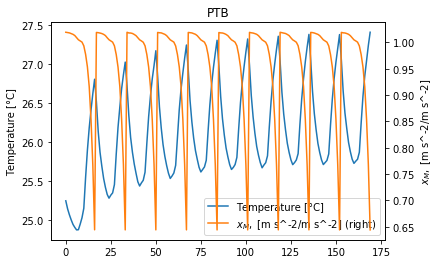

In [53]:
plot_vs_temp(temp_2_PTB,"Temperature [°C]",r"$x_{M},$ [m s^-2/m s^-2]",r"$x_{M},$ [m s^-2/m s^-2]","PTB")

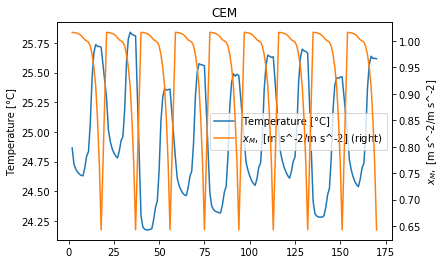

In [54]:
plot_vs_temp(temp_2_CEM,"Temperature [°C]",r"$x_{M},$ [m s^-2/m s^-2]",r"$x_{M},$ [m s^-2/m s^-2]","CEM")

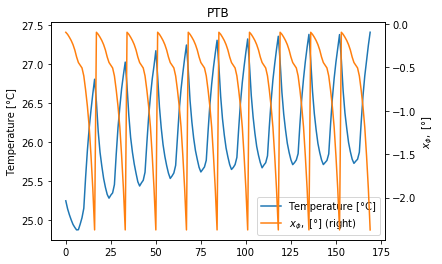

In [55]:
plot_vs_temp(temp_2_PTB,"Temperature [°C]",r"$x_{\phi},$ [°]",r"$x_{\phi},$ [°]","PTB")

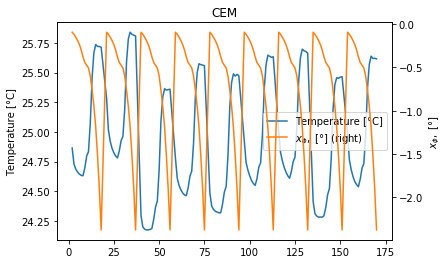

In [56]:
plot_vs_temp(temp_2_CEM,"Temperature [°C]",r"$x_{\phi},$ [°]",r"$x_{\phi},$ [°]","CEM")

In [173]:
temp_2_PTB=temp_2_PTB.sort_values(by=["Frequency [Hz]"])
temp_2_CEM=temp_2_CEM.sort_values(by=["Frequency [Hz]"])

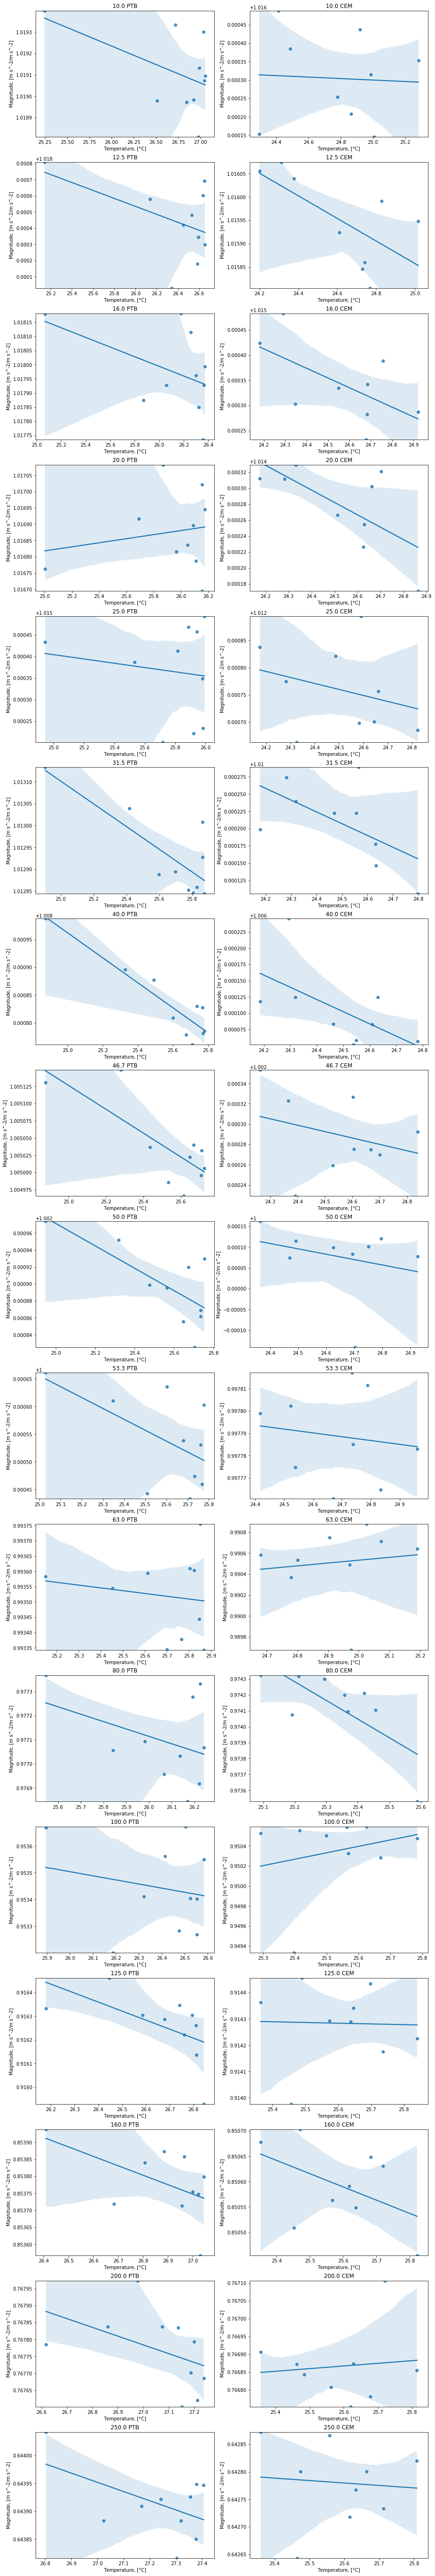

In [57]:
list_freq=whole_dataset_PTB["Frequency [Hz]"].unique()
f,ax=plt.subplots(nrows=len(list_freq),ncols=2,figsize=(15,100))
for i,val in enumerate(list_freq):
    result1=temp_2_PTB.loc[temp_2_PTB["Frequency [Hz]"].values==val,:]
    sns.regplot(x=result1["Temperature [°C]"].values, y=result1[r"$x_{M},$ [m s^-2/m s^-2]"].values, ax=ax[i,0])
    ax[i,0].set_ylim([result1[r"$x_{M},$ [m s^-2/m s^-2]"].min(), result1[r"$x_{M},$ [m s^-2/m s^-2]"].max()])
    ax[i,0].set_title(str(val)+ " PTB")
    ax[i,0].set_xlabel("Temperature, [°C]")
    ax[i,0].set_ylabel("Magnitude, [m s^-2/m s^-2]")
    result1=temp_2_CEM.loc[temp_2_CEM["Frequency [Hz]"].values==val,:]
    sns.regplot(x=result1["Temperature [°C]"].values, y=result1[r"$x_{M},$ [m s^-2/m s^-2]"].values, ax=ax[i,1])
    ax[i,1].set_ylim([result1[r"$x_{M},$ [m s^-2/m s^-2]"].min(), result1[r"$x_{M},$ [m s^-2/m s^-2]"].max()])
    ax[i,1].set_title(str(val)+" CEM")
    ax[i,1].set_xlabel("Temperature, [°C]")
    ax[i,1].set_ylabel("Magnitude, [m s^-2/m s^-2]")

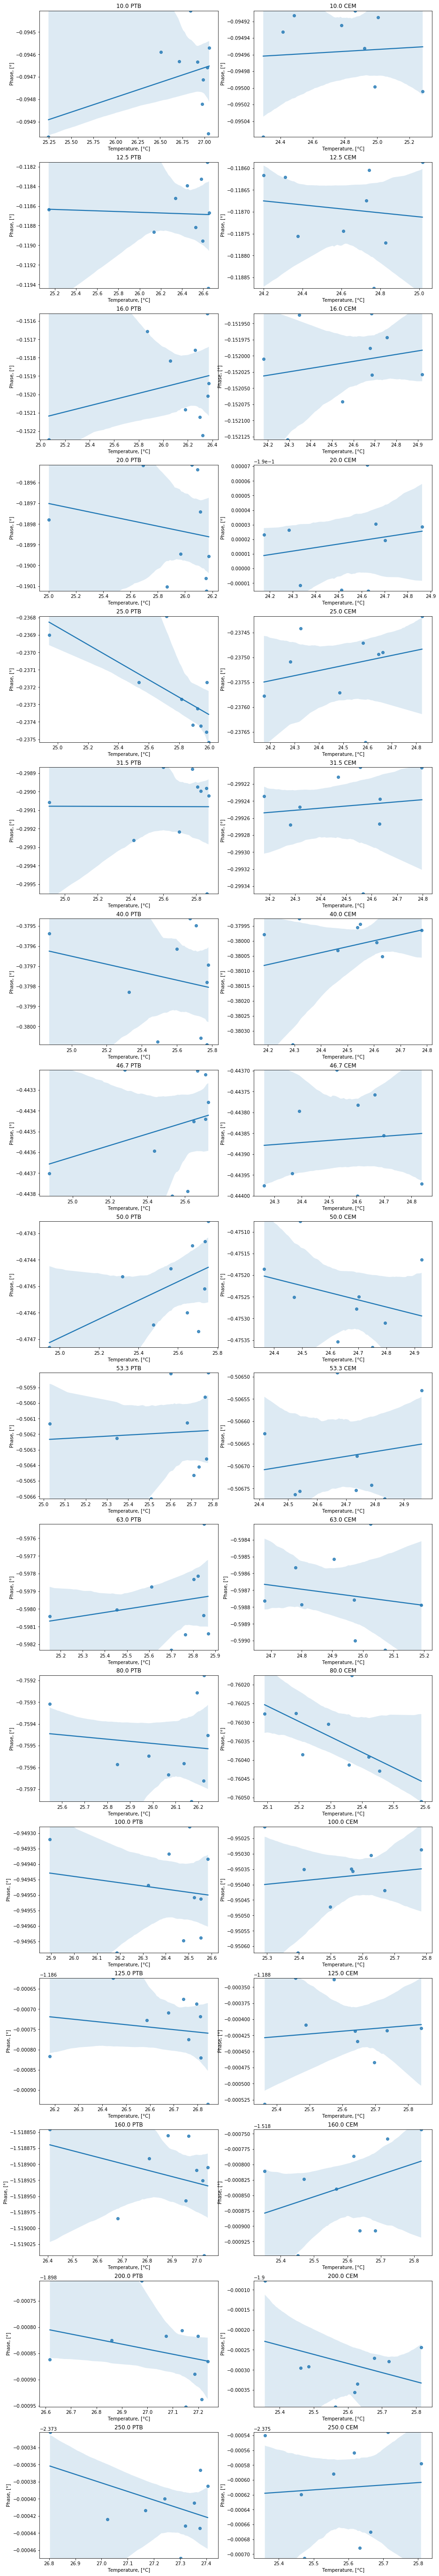

In [58]:
list_freq=whole_dataset_PTB["Frequency [Hz]"].unique()
f,ax=plt.subplots(nrows=len(list_freq),ncols=2,figsize=(15,100))
for i,val in enumerate(list_freq):
    result1=temp_2_PTB.loc[temp_2_PTB["Frequency [Hz]"].values==val,:]
    sns.regplot(x=result1["Temperature [°C]"].values, y=result1[r"$x_{\phi},$ [°]"].values, ax=ax[i,0])
    ax[i,0].set_ylim([result1[r"$x_{\phi},$ [°]"].min(), result1[r"$x_{\phi},$ [°]"].max()])
    ax[i,0].set_title(str(val)+ " PTB")
    ax[i,0].set_xlabel("Temperature, [°C]")
    ax[i,0].set_ylabel("Phase, [°]")
    result1=temp_2_CEM.loc[temp_2_CEM["Frequency [Hz]"].values==val,:]
    sns.regplot(x=result1["Temperature [°C]"].values, y=result1[r"$x_{\phi},$ [°]"].values, ax=ax[i,1])
    ax[i,1].set_ylim([result1[r"$x_{\phi},$ [°]"].min(), result1[r"$x_{\phi},$ [°]"].max()])
    ax[i,1].set_title(str(val)+" CEM")
    ax[i,1].set_xlabel("Temperature, [°C]")
    ax[i,1].set_ylabel("Phase, [°]")

The Pearson correlation coefficients  between:
<br> magnitude and temeperature and 
<br> phase and temperature 

are calculated at each frequency for PTB and CEM. The correlation coefficients are mostly negative, which are in line with the previous statement about the opposite behaviour. The correlation can be further examined by significance testing (p-value can be calculated). However, some guidelines for the values of correlation coefficients have been found in literature and shown on the Figure below:
    
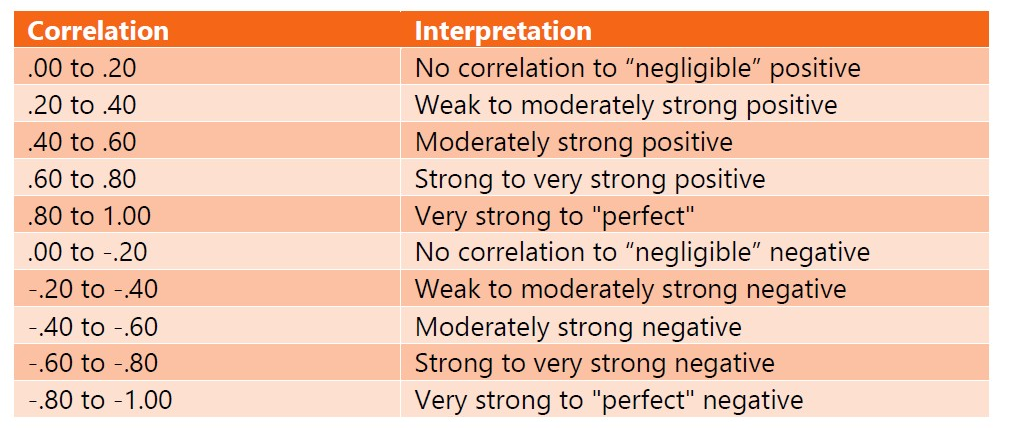
   

In [59]:
def Pearson_correlation(data,col1,col2):
    list_freq=data["Frequency [Hz]"].unique()
    corr_coef=np.zeros(len(list_freq))
    ci=np.zeros((len(list_freq),2))
    pval=np.zeros(len(list_freq))
    for i,val in enumerate(list_freq):
        data1=data.loc[data["Frequency [Hz]"].values==val,:]
        corr_coef[i],pval[i] = stats.pearsonr(data1[col1].values,data1[col2].values)
        se = 1/np.sqrt(len(data1)-3)
        r_z = np.arctanh(corr_coef[i])
        alpha = 0.05
        z = stats.norm.ppf(1-alpha/2)
        lo_z, hi_z = r_z-z*se, r_z+z*se
        lo, hi = np.tanh((lo_z, hi_z))
        ci[i,0]=lo
        ci[i,1]=hi
    return corr_coef,ci,pval

In [60]:
corr_magnitude=np.zeros((len(temp_2_PTB["Frequency [Hz]"].unique()),2))
corr_magnitude[:,0],ci_PTB_magnitude,p_PTB_magnitude=Pearson_correlation(temp_2_PTB,"Temperature [°C]",r"$x_{M},$ [m s^-2/m s^-2]")
corr_magnitude[:,1],ci_CEM_magnitude,p_CEM_magnitude=Pearson_correlation(temp_2_CEM,"Temperature [°C]",r"$x_{M},$ [m s^-2/m s^-2]")
corr_magnitude=pd.DataFrame(corr_magnitude, columns=["PTB","CEM"],index=temp_2_PTB["Frequency [Hz]"].unique())

The lower and upper limits of a confidence interval for correlation coefficients have different sign at all frequencies except between 31.5 Hz and 50.0 Hz for PTB and at all frequencies except 80.0 Hz for CEM which means that it cannot be fully accepted that the correlation is negative.

In [61]:
CI_val=np.concatenate((ci_PTB_magnitude,ci_CEM_magnitude),axis=1)
CI_val_magnitude=pd.DataFrame(CI_val,columns=['PTB_lower','PTB_upper','CEM_lower', "CEM_upper"], index=temp_2_PTB["Frequency [Hz]"].unique())

In [62]:
CI_val_magnitude

PTB_lower  PTB_upper  CEM_lower  CEM_upper
10.0   -0.862184   0.177886  -0.692550   0.633633
12.5   -0.850459   0.220122  -0.921212   0.003326
16.0   -0.848217   0.227765  -0.904430   0.103887
20.0   -0.501484   0.730737  -0.921652   0.000412
25.0   -0.710982   0.531638  -0.800226   0.462953
31.5   -0.950138  -0.337801  -0.897549   0.139912
40.0   -0.982005  -0.701011  -0.900840   0.123018
46.7   -0.944341  -0.286844  -0.803144   0.456513
50.0   -0.929030  -0.168055  -0.790261   0.483987
53.3   -0.879045   0.109603  -0.738347   0.574000
63.0   -0.713404   0.528104  -0.588703   0.728078
80.0   -0.815299   0.326548  -0.938754  -0.126470
100.0  -0.737047   0.491177  -0.501173   0.781585
125.0  -0.879320   0.108405  -0.679444   0.648221
160.0  -0.870221   0.146541  -0.865228   0.278935
200.0  -0.838714   0.258754  -0.602601   0.717796
250.0  -0.863433   0.173152  -0.708465   0.614556

Additional check is made by the calculation of the p-value. p-value evaluates how well the data rejects the null hypothesis, which states that there is no relationship between two compared groups. Successfully rejecting this hypothesis tells that results may be statistically significant.  Alpha is usually set to 0.05, meaning the probability of achieving the same or more extreme results assuming the null hypothesis is 5%. If the p-value is less than the specified alpha value, the null hypothesis is rejected.

In [63]:
p_val_magnitude=np.zeros((len(p_PTB_magnitude),2))
p_val_magnitude[:,0]=p_PTB_magnitude
p_val_magnitude[:,1]=p_CEM_magnitude

p_val_magnitude=pd.DataFrame(p_val_magnitude,columns=['PTB', "CEM"], index=temp_2_PTB["Frequency [Hz]"].unique())
p_val_magnitude.style.applymap(lambda x: 'background-color : green' if x<0.05 else 'background-color : red')

The null hypothesis that states that there is no relationships between magnitude and temperature can be rejected at frequencies between 31.5 Hz and 50.0 Hz for PTB  and at 80.0 Hz for CEM because the p-values are less than 0.05. 

In [64]:
corr_magnitude.head(2)

PTB       CEM
10.0 -0.508717 -0.052639
12.5 -0.475391 -0.662258

The same procedure is now applied to the examination of the relationship between phase values and temperature.

In [65]:
corr_phase=np.zeros((len(temp_2_PTB["Frequency [Hz]"].unique()),2))
corr_phase[:,0],ci_PTB_phase,p_PTB_phase=Pearson_correlation(temp_2_PTB,"Temperature [°C]",r"$x_{\phi},$ [°]")
corr_phase[:,1],ci_CEM_phase,p_CEM_phase=Pearson_correlation(temp_2_CEM,"Temperature [°C]",r"$x_{\phi},$ [°]")
corr_phase=pd.DataFrame(corr_phase, columns=["PTB","CEM"],index=temp_2_PTB["Frequency [Hz]"].unique())

In [66]:
corr_phase.head(2)

PTB       CEM
10.0  0.414618  0.069142
12.5 -0.045282 -0.125700

In [67]:
CI_val=np.concatenate((ci_PTB_phase,ci_CEM_phase),axis=1)
CI_val_phase=pd.DataFrame(CI_val,columns=['PTB_lower','PTB_upper','CEM_lower', "CEM_upper"], index=temp_2_PTB["Frequency [Hz]"].unique())

In [68]:
CI_val_phase.head()

PTB_lower  PTB_upper  CEM_lower  CEM_upper
10.0  -0.290967   0.828072  -0.623615   0.701072
12.5  -0.656199   0.601494  -0.728967   0.587463
16.0  -0.419849   0.775542  -0.529032   0.766384
20.0  -0.737253   0.490834  -0.539068   0.760526
25.0  -0.917261  -0.089648  -0.479110   0.792633

In [69]:
p_val_phase=np.zeros((len(p_PTB_phase),2))
p_val_phase[:,0]=p_PTB_phase
p_val_phase[:,1]=p_CEM_phase

p_val_phase=pd.DataFrame(p_val_phase,columns=['PTB', "CEM"], index=temp_2_PTB["Frequency [Hz]"].unique())
p_val_phase.style.applymap(lambda x: 'background-color : green' if x<0.05 else 'background-color : red')

The null hypothesis that states that there is no relationships between phase and temperature can be rejected only at a frequency of 25.0 Hz for PTB because the p-value is less than 0.05.

## 3.5.1 The correlation from sampling

From introduction plots in 3.1, it can be visible that data of interest for PTB and CEM is overlapping once when uncertainties are included. The previous correlation coefficients have not included the influence of uncertainties. In order to see the effect of uncertainties on correlation coefficients, data is sampled from the normal distribution defined by the mean value at a specific experiment and its standard deviation - given as the expanded uncertainty divided by 2. Then, the mean correlation coefficient is calculated. This is built as some kind of an abbreviated Monte Carlo method and performed for the joint data only, but can be applied for the separate conditions for PTB and CEM.

In [71]:
def Pearson_correlation_sampling(data,col1,col2,col3):
    list_freq=data["Frequency [Hz]"].unique()
    corr_coef=np.zeros(len(list_freq))
    for i,val in enumerate(list_freq):
        data1=data.loc[data["Frequency [Hz]"].values==val,:]
        corr_coef1=np.zeros(50)
        x=np.zeros((len(data1),50))
        for a,item in enumerate(data1.index):
            x[a,:]=np.random.normal(data1[col2].values[a],data1[col3].values[a]/2,50)
        for col in range(x.shape[1]):
            corr_coef1[col],_ = stats.pearsonr(data1[col1].values,x[:,col])
        corr_coef[i]=corr_coef1.mean()
    return corr_coef

In [72]:
corr_magnitude_sampled_PTB=np.zeros(len(temp_2_PTB["Frequency [Hz]"].unique()))
corr_magnitude_sampled_PTB=Pearson_correlation_sampling(temp_2_PTB,"Temperature [°C]",r"$x_{M},$ [m s^-2/m s^-2]",r"$U_{M},$ [m s^-2/m s^-2]")

In [73]:
corr_phase_sampled_PTB=np.zeros(len(temp_2_PTB["Frequency [Hz]"].unique()))
corr_phase_sampled_PTB=Pearson_correlation_sampling(temp_2_PTB,"Temperature [°C]",r"$x_{\phi},$ [°]",r"$U_{\phi},$ [°]")

In [74]:
corr_magnitude_sampled_PTB

array([-0.03901541, -0.03681162,  0.03118129, -0.04043049,  0.02890547,
       -0.12695453, -0.18033041, -0.17746711, -0.13479132, -0.05490249,
       -0.0740629 , -0.06334878,  0.03662072, -0.05393504, -0.07059313,
       -0.06128494,  0.00991892])

In [75]:
corr_phase_sampled_PTB

array([ 0.05729446, -0.00366988,  0.08170875, -0.02448201, -0.00660787,
       -0.06685966, -0.03438431, -0.05164298,  0.01550402,  0.14348362,
       -0.07715585,  0.08737546, -0.03843436,  0.01030523,  0.00296452,
       -0.0258055 , -0.01995376])

In [76]:
corr_magnitude_sampled_CEM=np.zeros(len(temp_2_CEM["Frequency [Hz]"].unique()))
corr_magnitude_sampled_CEM=Pearson_correlation_sampling(temp_2_CEM,"Temperature [°C]",r"$x_{M},$ [m s^-2/m s^-2]",r"$U_{M},$ [m s^-2/m s^-2]")

In [77]:
corr_phase_sampled_CEM=np.zeros(len(temp_2_CEM["Frequency [Hz]"].unique()))
corr_phase_sampled_CEM=Pearson_correlation_sampling(temp_2_CEM,"Temperature [°C]",r"$x_{\phi},$ [°]",r"$U_{\phi},$ [°]")

In [78]:
corr_magnitude_sampled_CEM

array([ 0.12487456,  0.00123801, -0.04313763,  0.00828676, -0.08776334,
       -0.01644134, -0.00580894, -0.03814444, -0.056379  , -0.06183689,
        0.06849884, -0.06945542,  0.06407499,  0.01865759, -0.07556513,
        0.0243447 , -0.013392  ])

In [79]:
corr_phase_sampled_CEM

array([ 0.04022771,  0.06469065, -0.02944179,  0.03243025,  0.01457869,
       -0.00024176, -0.06705151,  0.02844742,  0.02357903,  0.09045215,
        0.02768943, -0.02695304,  0.06273379,  0.01101847,  0.0402325 ,
        0.1299289 , -0.04795812])

According to this analysis, the correlation between magnitude and temperature  and between phase and temperature for both laboratories is negligible.

# 8. Datasets for the Excel validation

In [80]:
writer2 = pd.ExcelWriter('All_datasets.xlsx')

whole_dataset_CEM.to_excel(writer2, sheet_name = 'CEM', index = False)
whole_dataset_PTB.to_excel(writer2, sheet_name = 'PTB', index = False)

writer2.save()

# References

[1] https://www.investopedia.com/terms/c/coefficientofvariation.asp
<br>[2] https://en.wikipedia.org/wiki/Weighted_arithmetic_mean
<br>[3] https://en.wikipedia.org/wiki/Effective_sample_size
<br>[4] https://online.stat.psu.edu/stat500/lesson/10/10.2/10.2.1
<br>[5] https://www.marsja.se/levenes-bartletts-test-of-equality-homogeneity-of-variance-in-python/